In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import seaborn as sns
import random
import os
from os.path import join, basename
import pickle
from skimage import transform, io

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
import torch.nn.functional as F


from skimage import transform, io

from sklearn.preprocessing import LabelEncoder

from stats_utils import umap_reduce, pca
from scipy.cluster import hierarchy

from tqdm import tqdm

from neural import Autoencoder2D

from redundancy_remover import compress_seqs

import umap

In [50]:
count_path = "/oak/stanford/groups/horence/khoa/data/satc_count_data_TSP_10x_gap_0_published_TSP7_Blood/"

In [51]:
satc_cols =  ["replicate", "sample", "anchor", "target", "count"]

In [52]:
def get_sorted_count_marix(df):
    assert len(df.anchor.unique()) == 1
    # Create a dictionary to map each unique value to its index
    sample_index_map = {value: index for index, value in enumerate(df['sample'].unique())}
    target_index_map = {value: index for index, value in enumerate(df['target'].unique())}
    df = df.reset_index()
    # Map the values in the DataFrame using the dictionaries
    df.loc[:, "sample_index"] = df['sample'].map(sample_index_map)
    df.loc[:, "target_index"] = df['target'].map(target_index_map)
    pivot_table = df.pivot_table(index='target_index', columns='sample_index', \
                                        values='count', aggfunc='sum', fill_value=0)
    pivot_table = pivot_table.loc[pivot_table.sum(axis=1).sort_values(ascending=False).index]
    pivot_table = pivot_table[pivot_table.sum().sort_values(ascending=False).index]
    return np.asarray(pivot_table)

In [53]:
def plot_anchor_matrix(anchor_matrix_dict, anchor, max_sample_num = 20, max_target_num = 10):
    mat = anchor_matrix_dict[anchor]
    plt.imshow(mat[:max_target_num,:max_sample_num])
    print(mat.shape)

all_count_dfs = []
for count_data in os.listdir(count_path):
    path = join(count_path, count_data)
    df_count = pd.read_csv(path , sep = "\t")
    df_count.columns = satc_cols
    df_count = df_count[df_count["count"] > 1]
    all_count_dfs.append(df_count)

anchor_matrix_dict = {}
for i, df in enumerate(all_count_dfs):
    print("DONE: ", i)
    anchors = set(df.anchor)
    for anchor in anchors:
        anchor_df = df[df.anchor == anchor]
        count_matrix = get_sorted_count_marix(anchor_df)
        anchor_matrix_dict[anchor] = count_matrix

with open(join(count_path, 'anchor_dict.pickle'), 'wb') as pickle_file:
    pickle.dump(anchor_matrix_dict, pickle_file)

In [54]:
with open(join(count_path, 'anchor_dict.pickle'), 'rb') as pickle_file:
    data_master = pickle.load(pickle_file)

In [55]:
bad_anchor = []
for anchor, cm in data_master.items():
    if 1 in cm.shape:
        bad_anchor.append(anchor)
for a in bad_anchor:
    data_master.pop(a)
data_matrix = list(data_master.values())

In [56]:
class_path = "/oak/stanford/groups/horence/Roozbeh/NOMAD_10x/runs/TSP_10x_gap_0_published/TSP7/Blood/classified_anchors_adam_compactor.tsv"
df_class = pd.read_csv(class_path, sep = "\t")
df_class["compactor_length"] = df_class.compactor.apply(lambda x:len(x))
anchor_class_dict = df_class.set_index("anchor").to_dict()
df_anchor = pd.DataFrame(data_master.keys(), columns = ["anchor"])
df_anchor["vdj"] = df_anchor.anchor.map(anchor_class_dict["vdj"])
df_anchor["anchor_event"] = df_anchor.anchor.map(anchor_class_dict["anchor_event"])
df_anchor["splicing"] = df_anchor.anchor_event.apply(lambda x:x=="splicing") * 1
df_anchor["class"] = 0
df_anchor.loc[(df_anchor.vdj==1) & (df_anchor.splicing==1), "class"]  = 3
df_anchor.loc[(df_anchor.vdj==0) & (df_anchor.splicing==1), "class"]  = 1
df_anchor.loc[(df_anchor.vdj==1) & (df_anchor.splicing==0), "class"]  = 2
df_anchor["bpc1"] = (df_anchor["anchor_event"] == "Base_pair_change_1")*1

In [57]:
max_compactor_length_idx = df_class.groupby('anchor_index')['compactor_length'].idxmax()
df_class_max_length = df_class.loc[max_compactor_length_idx]
non_duplicated_seqs, non_duplicated_index = compress_seqs(df_class_max_length.compactor.to_list())
df_class_unique_anchors = df_class.groupby('anchor_index').anchor.agg(list).apply(lambda x:x[0]).reset_index()
deduplicated_anchor_list = df_class_unique_anchors.loc[non_duplicated_index,:].anchor.to_list()

Reduce from 5294 to 1724
Reduce from 1724 to 1403
Reduce from 1403 to 1352
Reduce from 1352 to 1336
Reduce from 1336 to 1330
Reduce from 1330 to 1329
Reduce from 1329 to 1329


In [58]:
data_master_deduplicated = {}
for anchor, count_matrix in data_master.items():
    if anchor in deduplicated_anchor_list:
        data_master_deduplicated[anchor] = count_matrix
data_matrix = list(data_master_deduplicated.values())

In [59]:
df_anchor = df_anchor[(df_anchor.anchor.isin(deduplicated_anchor_list)) & (~df_anchor.anchor.isin(bad_anchor))]

In [60]:
index_list = list(df_anchor[df_anchor.vdj == 1].index)

In [61]:
def resize_matrix(matrix, new_shape):
    resized_image = transform.resize(matrix, new_shape, anti_aliasing=True)
    return resized_image

def pad_matrix(matrix, output_shape, pad_token):
    """
    Pads a matrix with zeros to get to an input shape.

    Args:
    matrix: The matrix to be padded.
    output_shape: The desired output shape.

    Returns:
    The padded matrix.
    """
    matrix = torch.tensor(matrix)
    # Get the current shape of the matrix
    current_shape = matrix.shape
    # Calculate the amount of padding needed
    padding_rows = output_shape[0] - current_shape[-2]
    padding_cols = output_shape[1] - current_shape[-1]
    # Pad the matrix with zeros
    padded_matrix = F.pad(matrix, (0,padding_cols,0,padding_rows), mode="constant", value=pad_token)
    return padded_matrix

In [62]:
def prep_matrix(matrix, truncate_shape = (12, 32), \
                output_shape = (12, 32),\
                clust_col = True,\
                clust_row=True,\
                pad = None):
    matrix = matrix[:truncate_shape[0],:truncate_shape[1]]
# z    matrix = matrix / matrix.sum()
    if clust_col:
        if np.any(np.isinf(matrix)) or np.any(np.isnan(matrix)):
            print(matrix)
            nan_indices = np.isnan(matrix)
            inf_indices = np.isinf(matrix)
            matrix[nan_indices] = 0
            matrix[inf_indices] = np.nanmax(matrix)
        linkage_matrix = hierarchy.linkage(matrix.T, method='ward')  # Transpose data to cluster by column
        dendro = hierarchy.dendrogram(linkage_matrix, no_plot=True)
        matrix = matrix[:, dendro["leaves"]]
        
    if clust_row:
        if np.any(np.isinf(matrix)) or np.any(np.isnan(matrix)):
            nan_indices = np.isnan(matrix)
            inf_indices = np.isinf(matrix)
            matrix[nan_indices] = 0
            matrix[inf_indices] = np.nanmax(matrix)
        linkage_matrix = hierarchy.linkage(matrix, method='ward')  # Transpose data to cluster by column
        dendro = hierarchy.dendrogram(linkage_matrix, no_plot=True)
        
        matrix = matrix[dendro["leaves"], :]
        
    if pad != None:
        resized_data = pad_matrix(matrix, output_shape, pad)
    else:
        resized_data = resize_matrix(matrix, output_shape)

    return resized_data

In [63]:
all_dat = []
for i in tqdm(range(len(data_matrix))):
#     try:
    dat = data_matrix[i]
    #dat = dat / dat.sum()
    #dat = dat / dat.sum(0, keepdims=True)
    dat = dat / dat.sum(0, keepdims=True)

    prepped_data = prep_matrix(dat, truncate_shape = (32, 32), \
                               output_shape = (32, 32),\
                               clust_col = True, clust_row=True, pad=-1)
    all_dat.append(prepped_data)
#     except:
#         print(dat)

100%|██████████| 1328/1328 [00:01<00:00, 703.52it/s]


In [64]:
all_dat_tensor = torch.tensor(np.asarray(all_dat))
all_dat_tensor = torch.unsqueeze(all_dat_tensor, 1)
all_dat_tensor.shape

torch.Size([1328, 1, 32, 32])

In [65]:
train_size = int(0.8 * len(all_dat))
val_size = int(0.1 * len(all_dat))
test_size = len(all_dat) - train_size - val_size
train_set, val_set, test_set = torch.utils.data.random_split(all_dat_tensor, [train_size, val_size, test_size])
print("train set size: ", len(train_set))
print("val set size: ", len(val_set))
print("test set size: ", len(test_set))
batch_size = 128
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

train set size:  1062
val set size:  132
test set size:  134


In [71]:
class WeightedMSELoss(nn.Module):
    def __init__(self, base, pad_token, weight_dict):
        super(WeightedMSELoss, self).__init__()
#         self.weight = weight
        self.base = base
        self.pad_token = pad_token
        self.weight_dict = weight_dict

    def forward(self, input_, target):
        # Calculate MSE loss
        mask = (target != self.pad_token).float()
        mask = mask*self.map_tensor(target, self.weight_dict) + self.base
        square_error = (input_ - target)**2
        weighted_square_error = square_error*mask
        loss = torch.mean(weighted_square_error)
#         mse_loss = nn.functional.mse_loss(input_*mask, target*mask, reduction='mean')
#         print(np.unique(mask.cpu().detach().numpy()))
        # Apply weight and bias for non-zero data
#         weighted_mse_loss = mse_loss + torch.sum(self.weight * non_zero_mask) + self.bias
        
        return loss
    
    @staticmethod
    def map_tensor(tensor, mapping_dict):
        map_tensor = torch.clone(tensor)
        exclude_list = torch.tensor(list(mapping_dict.keys()))
#         exclude_list = [round(i,3) for i in exclude_list]
#         print(exclude_list)
        # Map the tensor values based on the dictionary using torch.where()
        for key, value in mapping_dict.items():
            map_tensor = torch.where(map_tensor <= key, torch.tensor(value), map_tensor)
        mask = torch.ones_like(map_tensor, dtype=torch.bool)
        for val in exclude_list:
            mask = mask & (tensor > val)
        map_tensor[mask] = 1

#         map_tensor = torch.where(~torch.isin(mapped_tensor, exclude_list),\
#                                  torch.tensor(1), mapped_tensor)
        return map_tensor

In [72]:
# use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")
# Instantiate the model
# model = Autoencoder(num_channels=12, hidden_channels=24,\
#                        kernel_size=3, stride=2, padding=1, embedded_dims = 32, shape=(12,32))

model = Autoencoder2D(num_channels=1, hidden_channels=6,\
                        kernel_size=3, stride=1, padding=1,\
                        embedded_dims = 6, output_padding=0, shape=(1,32,32))
model.to(device)
# Choose a loss function (e.g., Mean Squared Error) and an optimizer (e.g., Adam)
# use cross entropy loss for classification
# cross_entropy = nn.CrossEntropyLoss()
criterion = nn.MSELoss()
criterion = WeightedMSELoss(pad_token=-1, base = 0.001, weight_dict={0.1:0.5})

optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 500
train_loss = []
val_loss = []
for epoch in range(num_epochs):
    
    # train in batch
    model.train()
    train_running_loss = 0.0

    for batch in train_loader:
#         batch = train_set[i:i+batch_size]
        batch = batch.float().to(device)
        outputs = model(batch)
        reconstruction_loss = criterion(outputs, batch)
        sparsity_loss = 0.000 * model.l1_regularization()
        loss = reconstruction_loss + sparsity_loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_running_loss += loss.item()
    train_loss.append(train_running_loss/len(train_loader))

    # # Forward pass
    # outputs = model(train_set.dataset[train_set.indices])
    # loss = criterion(outputs, train_set.dataset[train_set.indices])

    # # Backward pass and optimization
    # optimizer.zero_grad()
    # loss.backward()
    # optimizer.step()

    # Print progress
#     with torch.no_grad():
#         print("Sparsity_Loss = ", sparsity_loss.item())
#         outputs = model(train_set.dataset[train_set.indices])
#         train_loss_ = criterion(outputs, train_set.dataset[train_set.indices])
#         print(f'Epoch [{epoch + 1}/{num_epochs}]')
#         print(f'Train loss: {train_loss_.item():.4f}')
#         outputs = model(test_set.dataset[test_set.indices])
#         test_loss_ = criterion(outputs, test_set.dataset[test_set.indices])
#         print(f'Test loss: {test_loss_.item():.4f}')

    # save test loss and rain loss in lists
#     train_loss.append(train_loss_.item())
#     test_loss.append(test_loss_.item())

    
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for i, inputs in enumerate(val_loader):
            inputs = inputs.float().to(device)
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            val_running_loss += loss.item()
    val_loss.append(val_running_loss/len(val_loader))
    if epoch%10 == 0:
        print(sparsity_loss.cpu().detach().numpy())
        print(f"Epoch {epoch+1}, \nTrain loss: {train_running_loss/len(train_loader)}")
        print(f"Validation loss: {val_running_loss/len(val_loader)}")
        
# # Test the model
# with torch.no_grad():
#     outputs = model(test_set.dataset[test_set.indices])
#     loss = criterion(outputs, test_set.dataset[test_set.indices])
#     print(f'Test loss: {loss.item():.4f}')

Using cpu device
0.0
Epoch 1, 
Train loss: 0.03478881633943982
Validation loss: 0.03923247195780277
0.0
Epoch 11, 
Train loss: 0.018751930445432663
Validation loss: 0.018868896178901196
0.0
Epoch 21, 
Train loss: 0.011499414944814311
Validation loss: 0.0125361867249012
0.0
Epoch 31, 
Train loss: 0.009188430176840888
Validation loss: 0.009670327417552471
0.0
Epoch 41, 
Train loss: 0.007614799464742343
Validation loss: 0.007833146955817938
0.0
Epoch 51, 
Train loss: 0.0071284436206850744
Validation loss: 0.007333467248827219
0.0
Epoch 61, 
Train loss: 0.006753860093239281
Validation loss: 0.006944884778931737
0.0
Epoch 71, 
Train loss: 0.006247031554165814
Validation loss: 0.006280094385147095
0.0
Epoch 81, 
Train loss: 0.005048639244503445
Validation loss: 0.0047611522022634745
0.0
Epoch 91, 
Train loss: 0.004168340004980564
Validation loss: 0.0038876576581969857
0.0
Epoch 101, 
Train loss: 0.00370777421630919
Validation loss: 0.003487209673039615
0.0
Epoch 111, 
Train loss: 0.003393430

KeyboardInterrupt: 

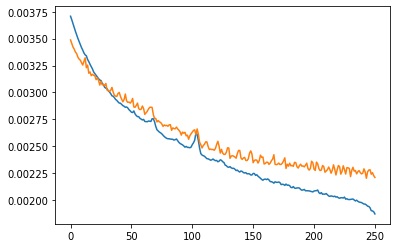

In [73]:
plt.plot(train_loss[100:])
plt.plot(val_loss[100:])

In [74]:
test_loss = []
model.eval()
test_running_loss = 0.0
with torch.no_grad():
    for i, inputs in enumerate(test_loader):
        inputs = inputs.float().to(device)
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        test_running_loss += loss.item()
test_loss.append(test_running_loss/len(test_loader))
print(test_loss)

[0.0021239868365228176]


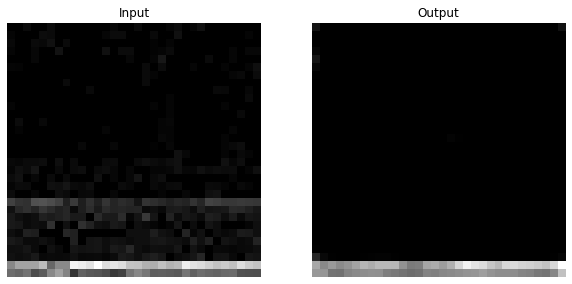

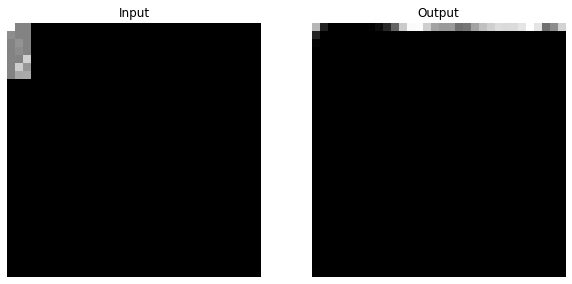

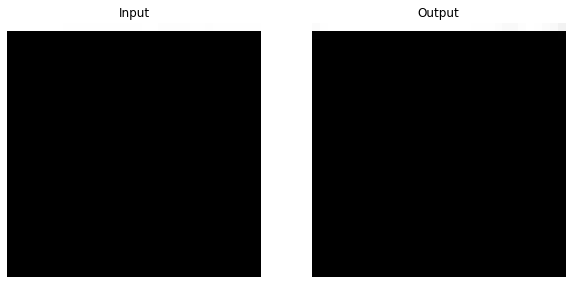

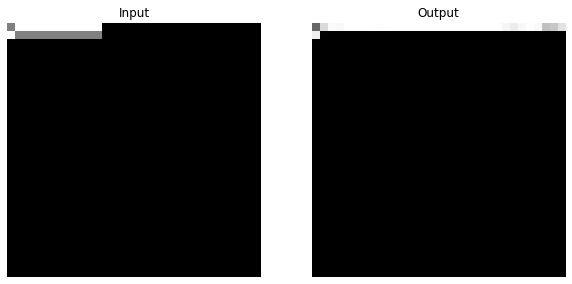

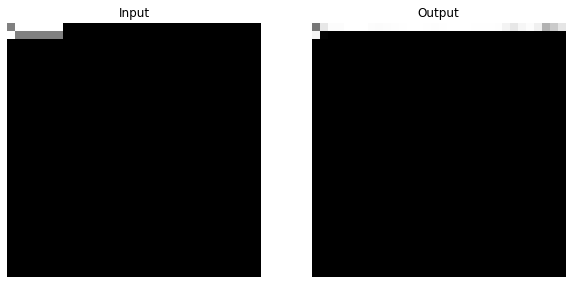

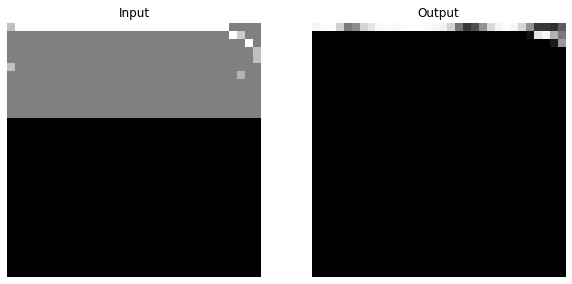

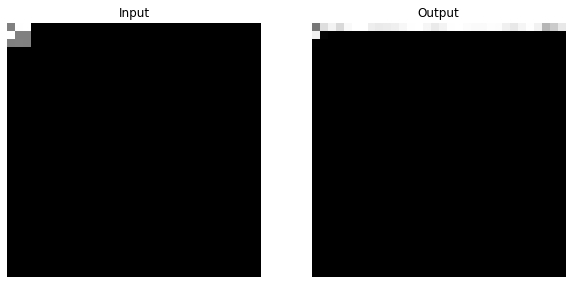

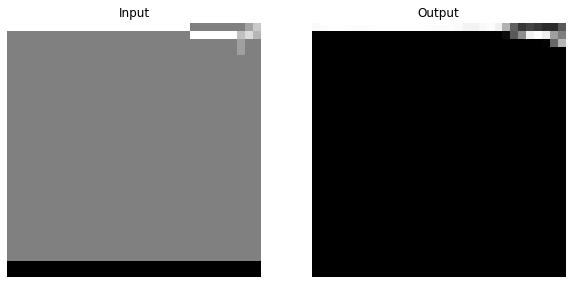

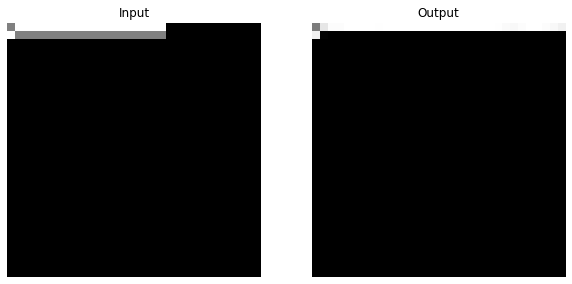

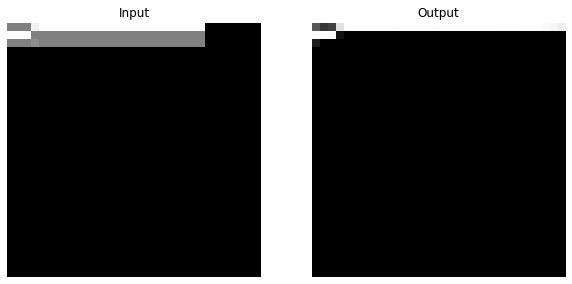

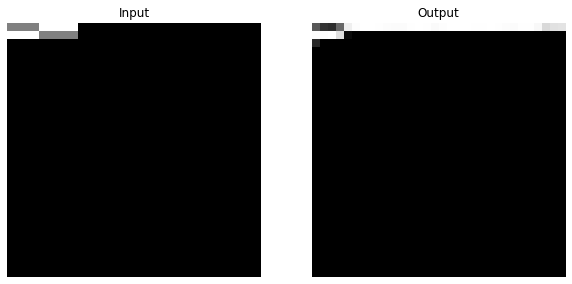

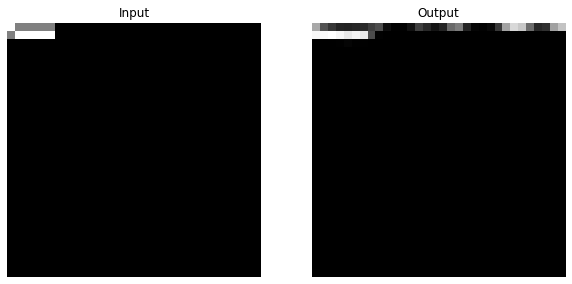

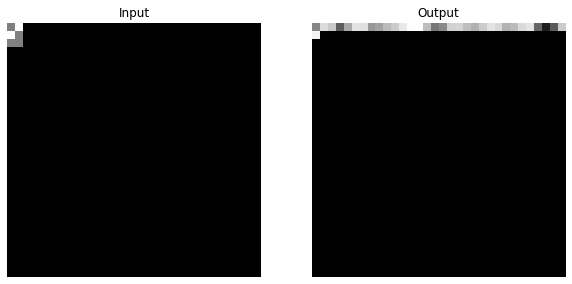

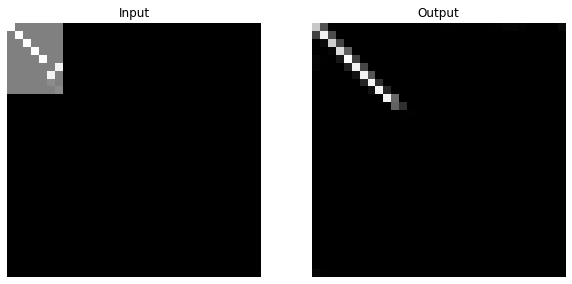

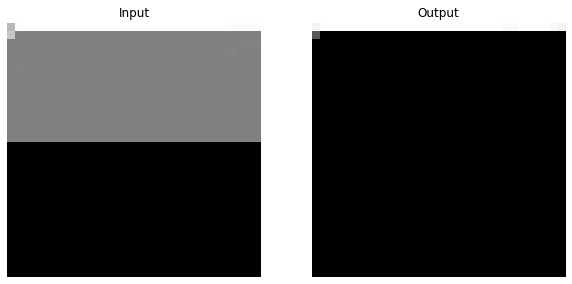

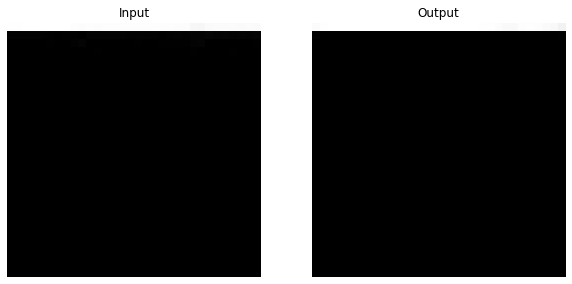

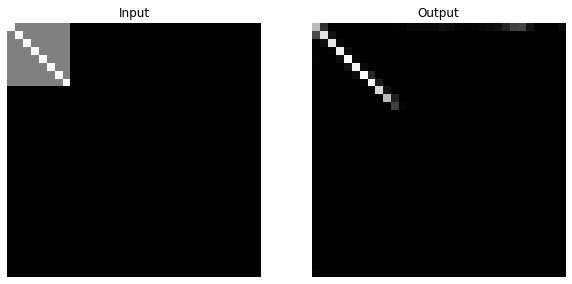

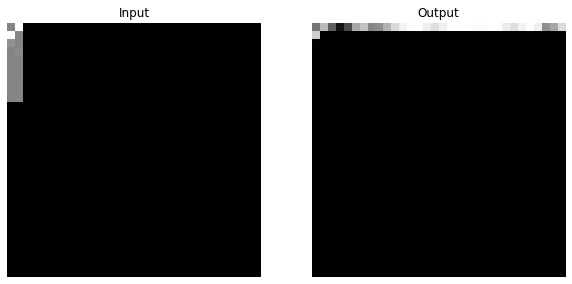

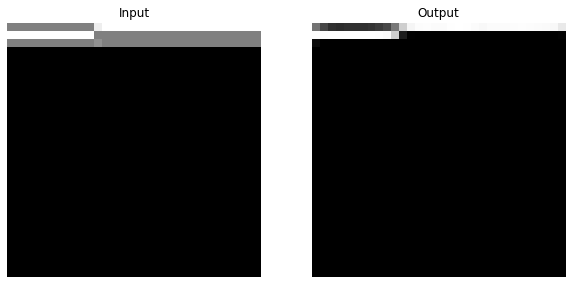

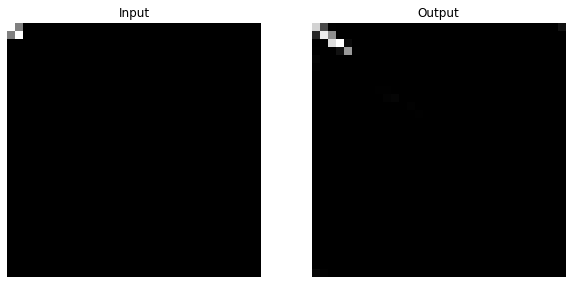

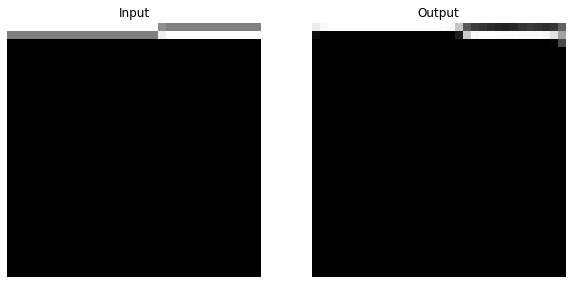

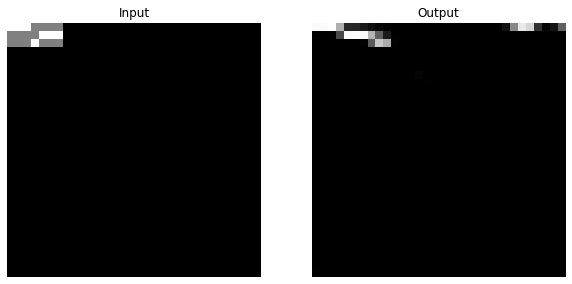

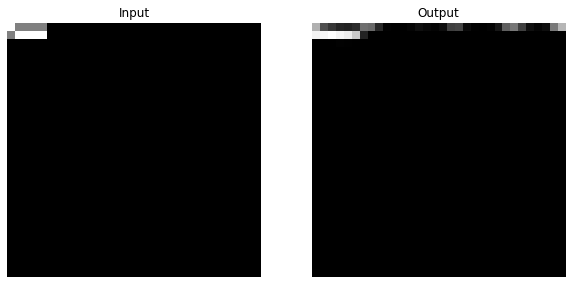

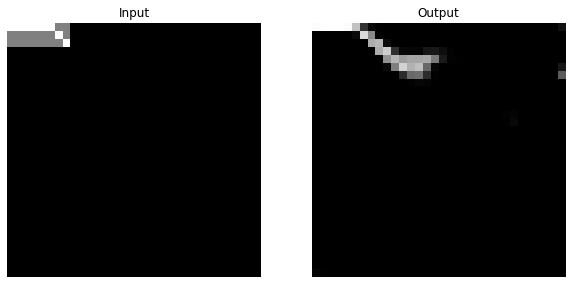

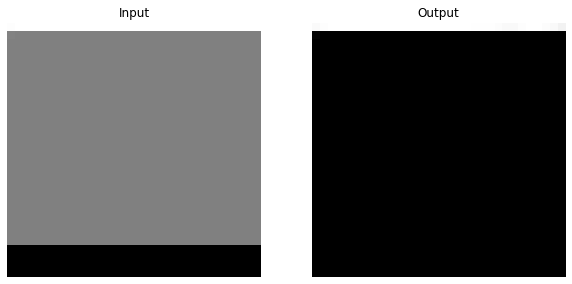

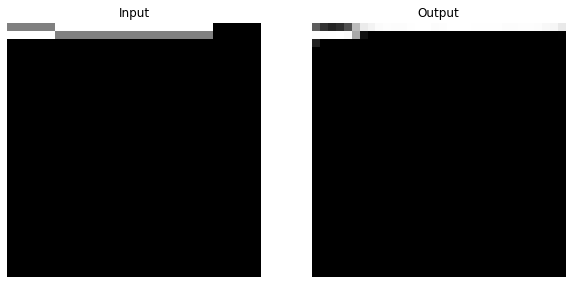

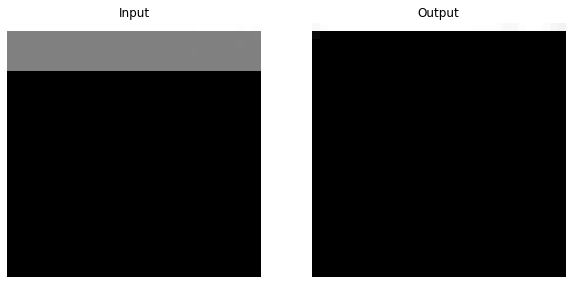

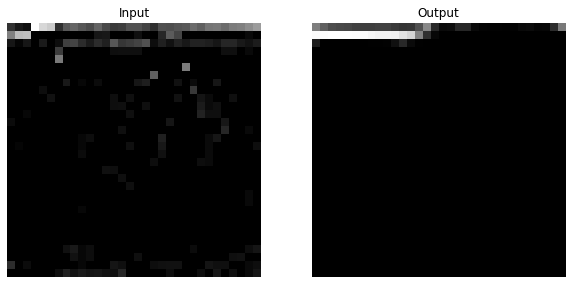

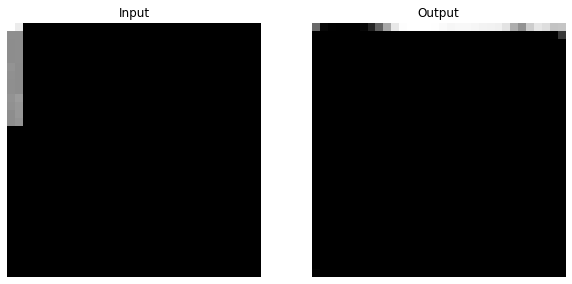

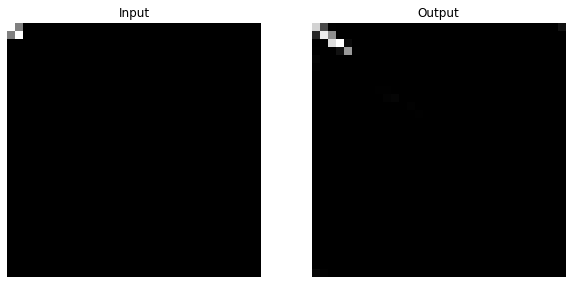

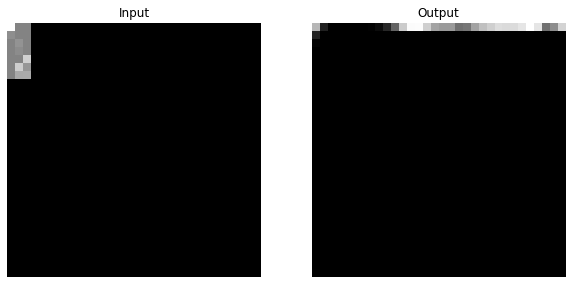

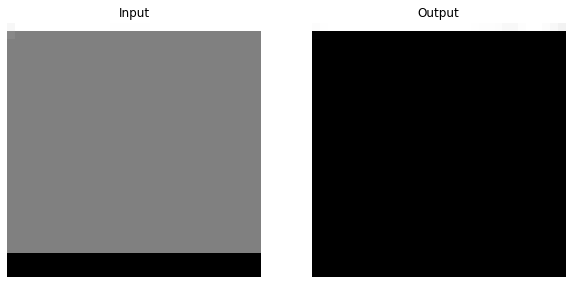

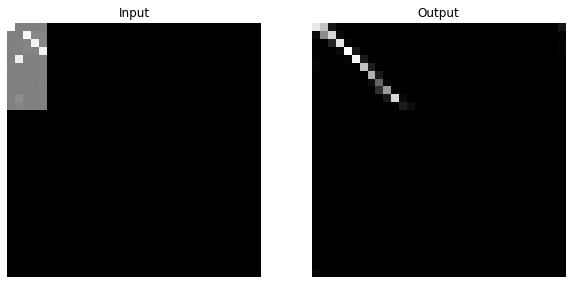

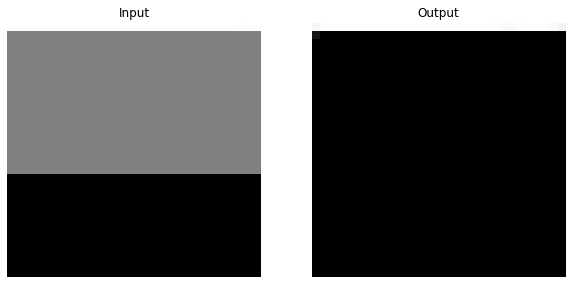

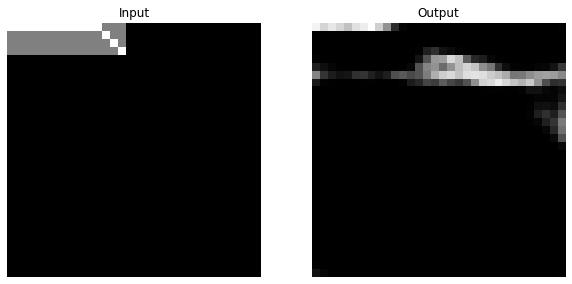

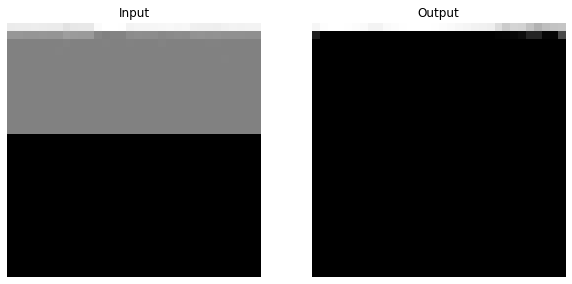

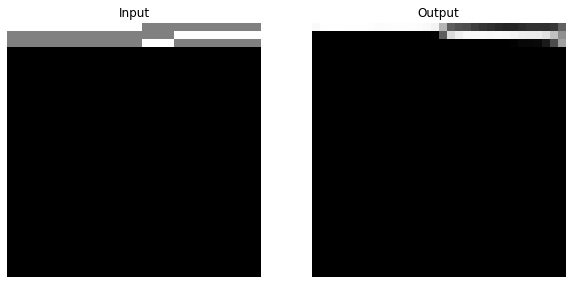

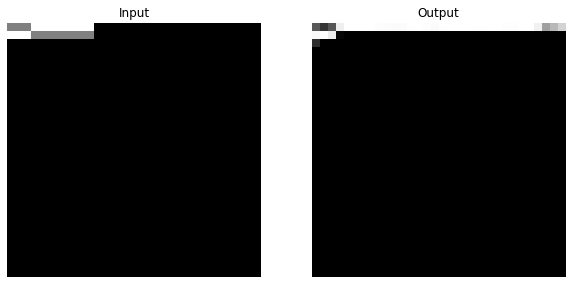

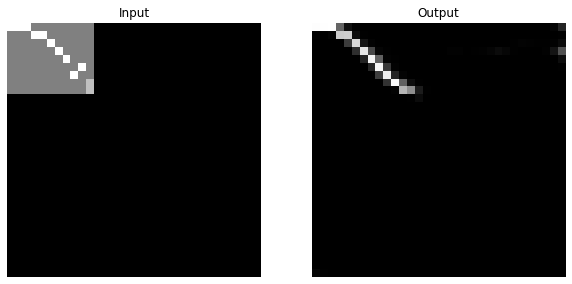

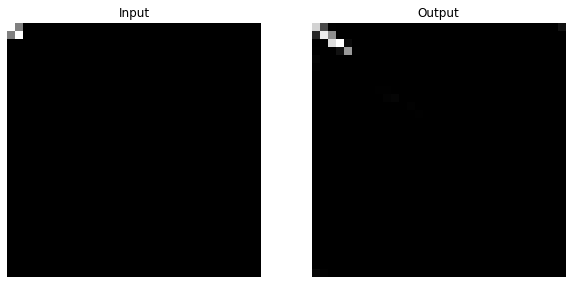

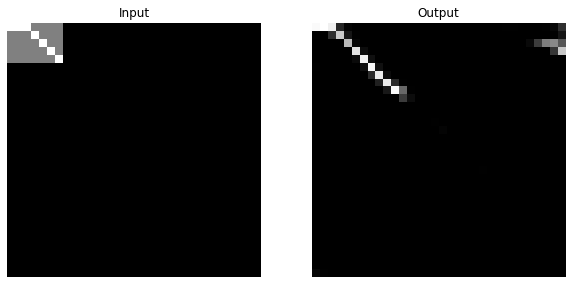

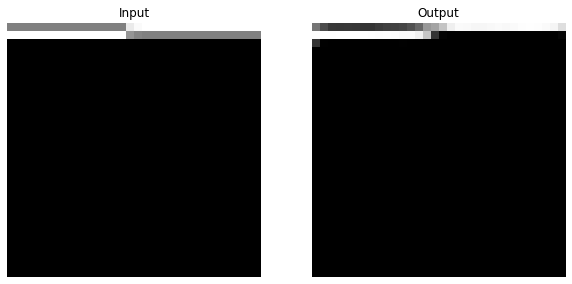

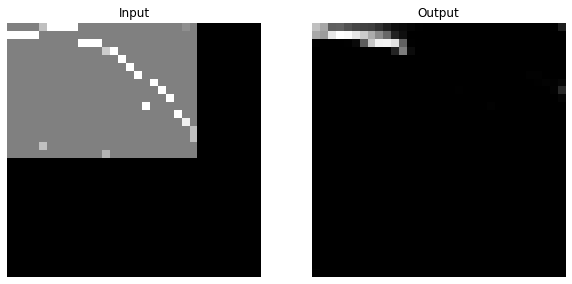

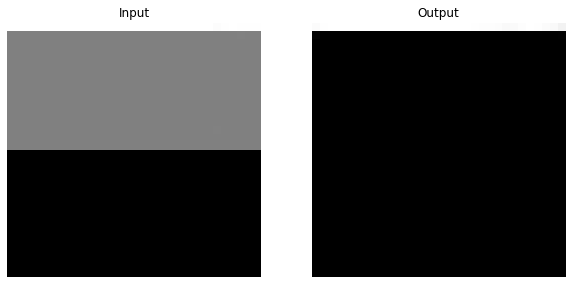

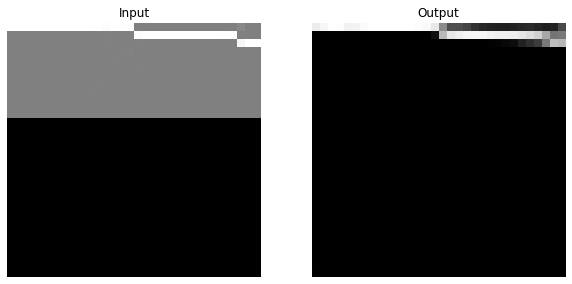

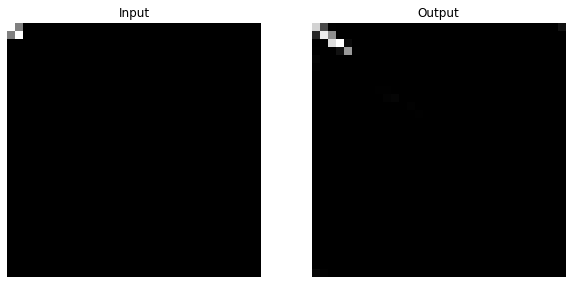

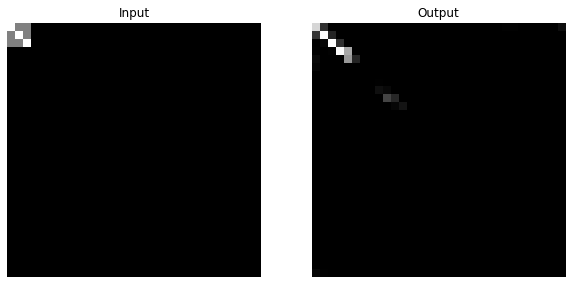

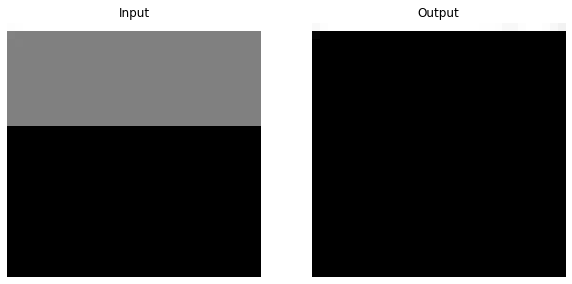

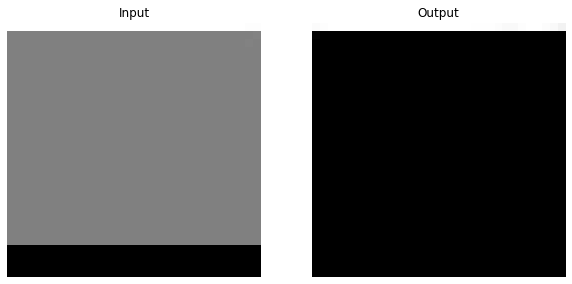

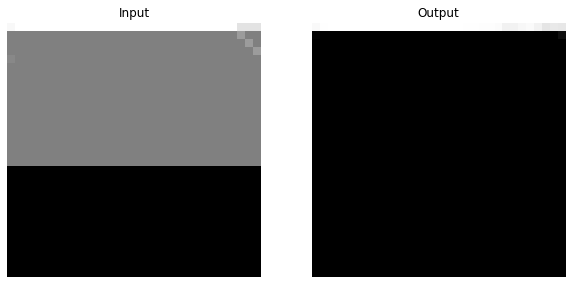

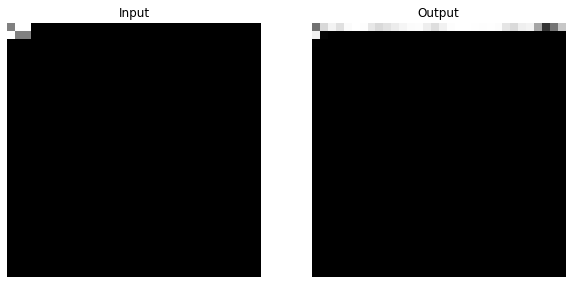

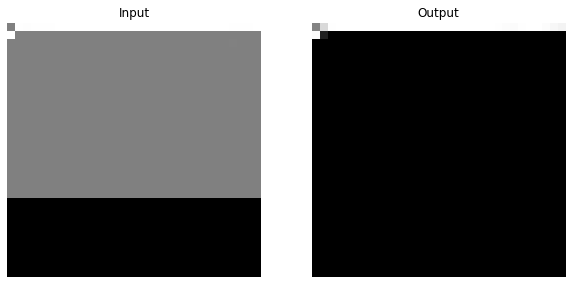

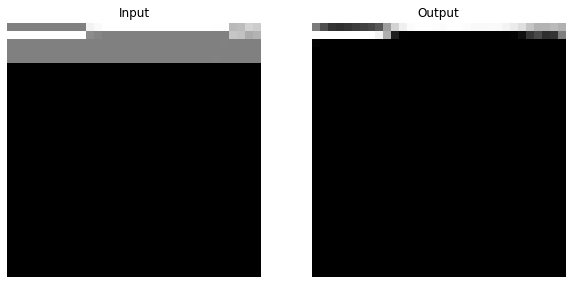

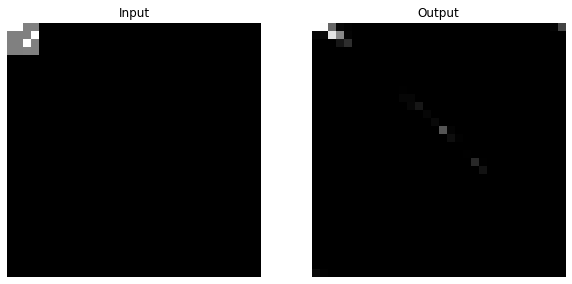

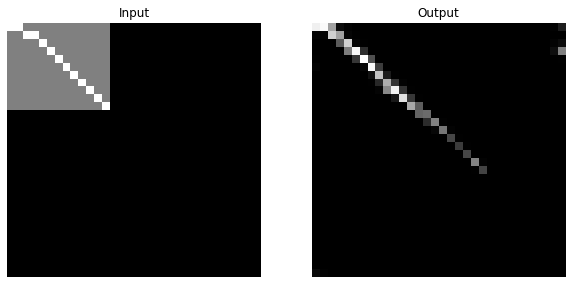

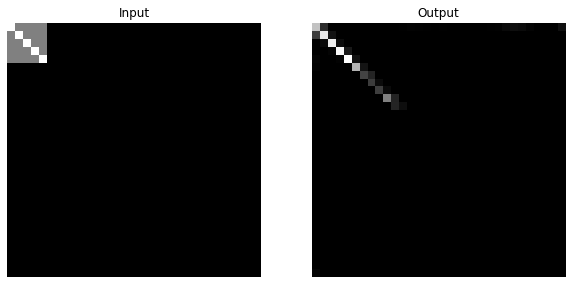

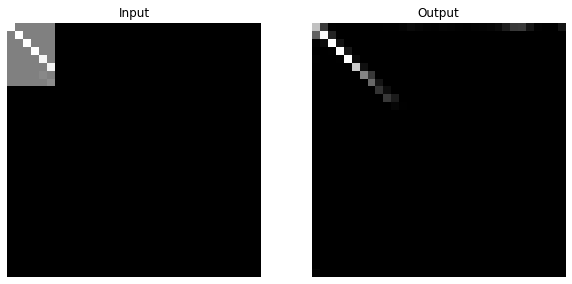

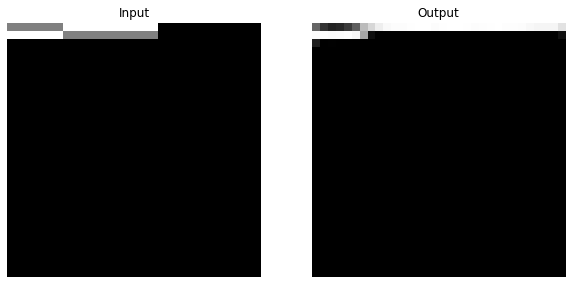

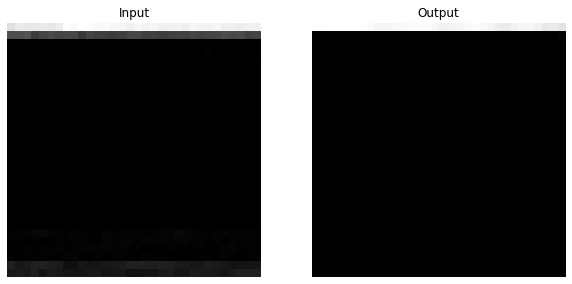

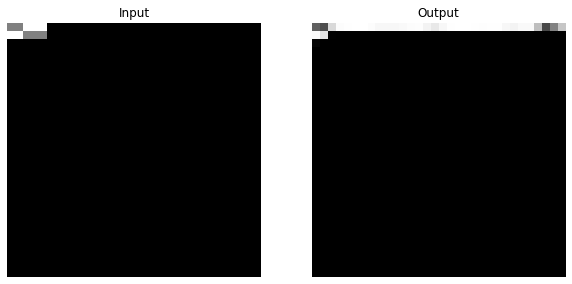

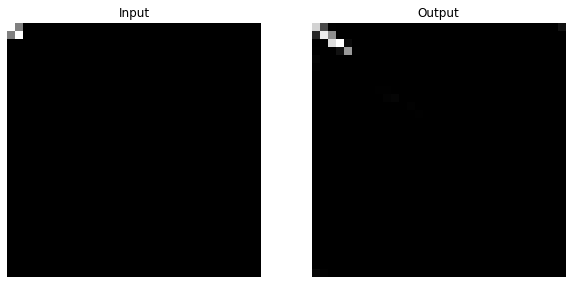

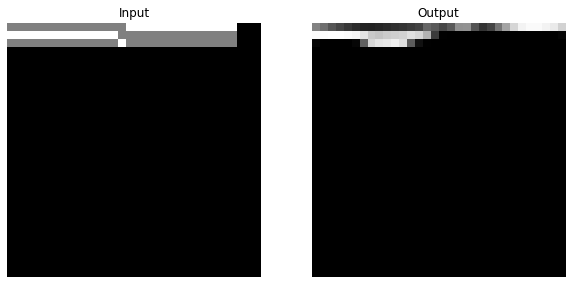

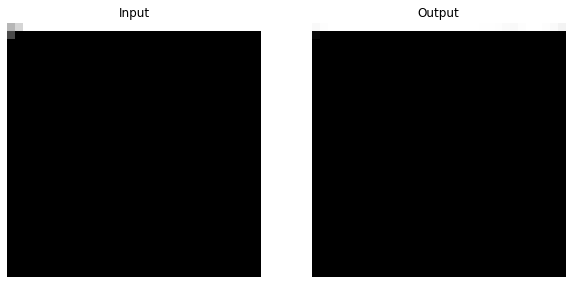

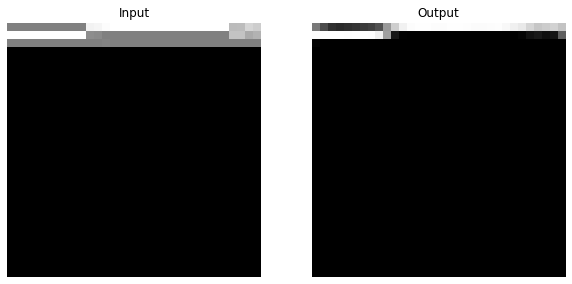

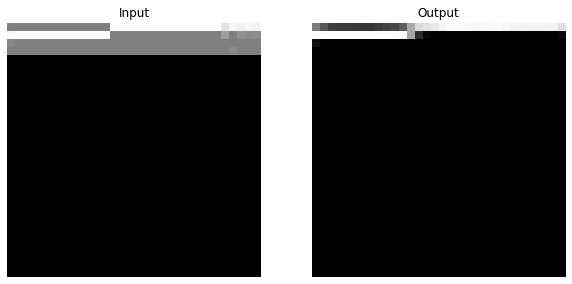

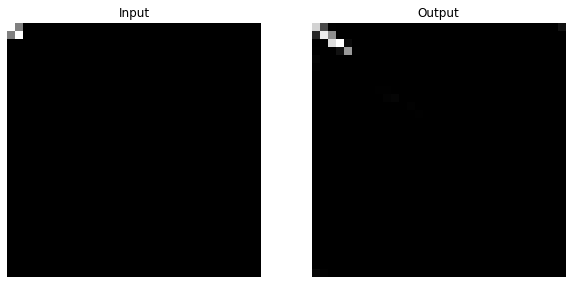

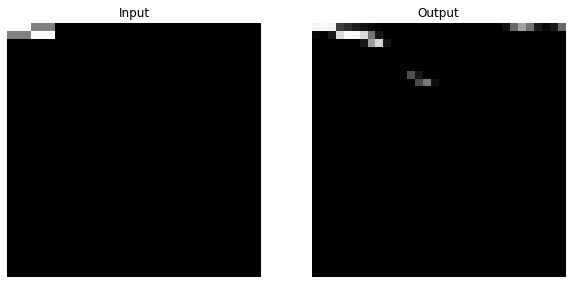

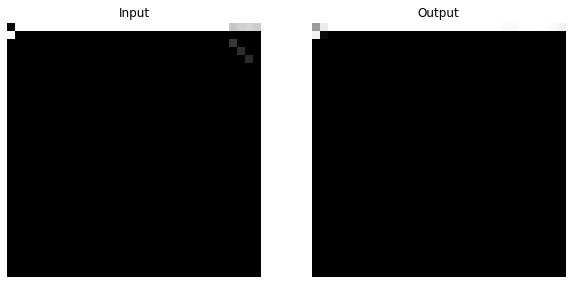

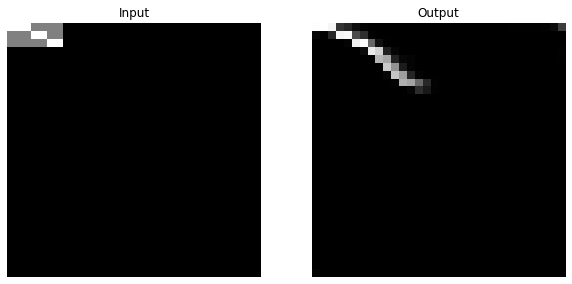

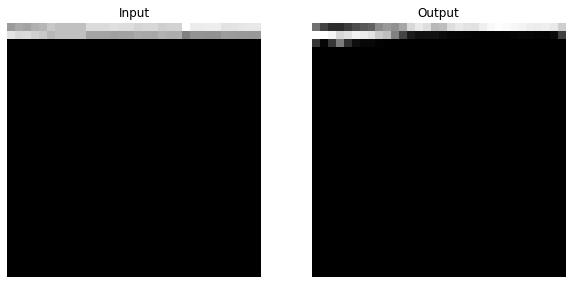

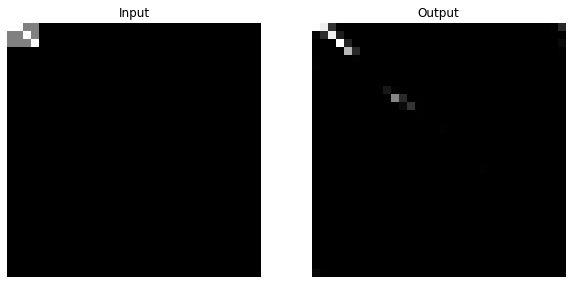

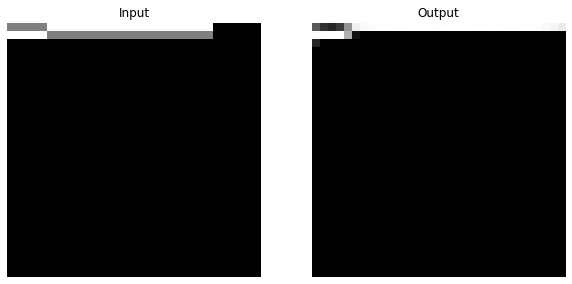

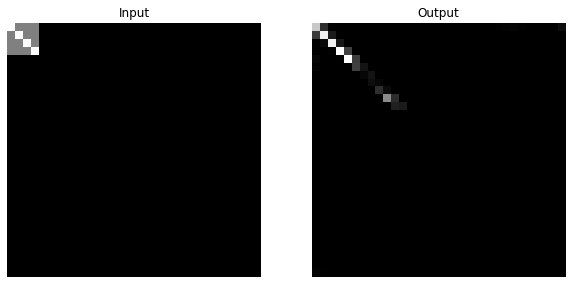

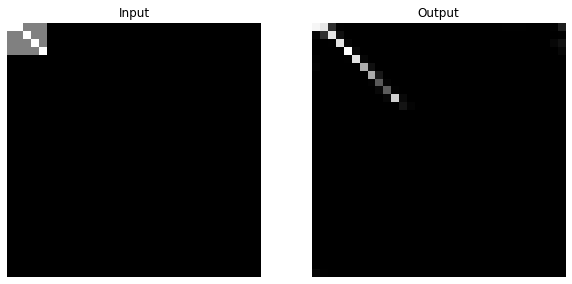

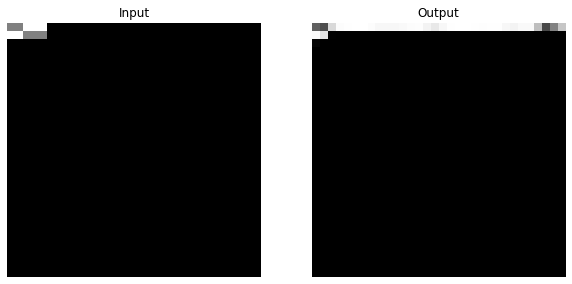

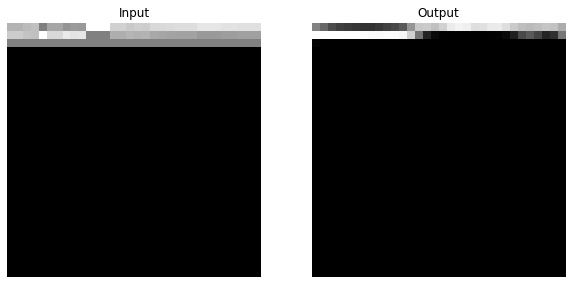

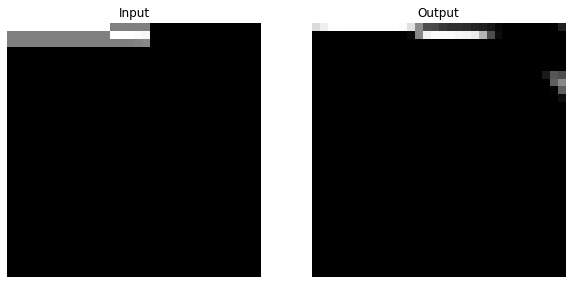

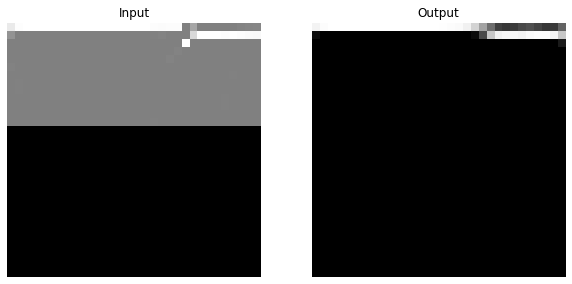

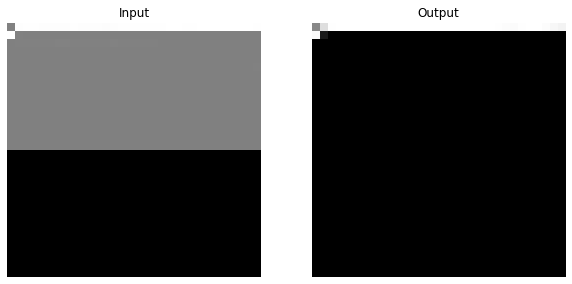

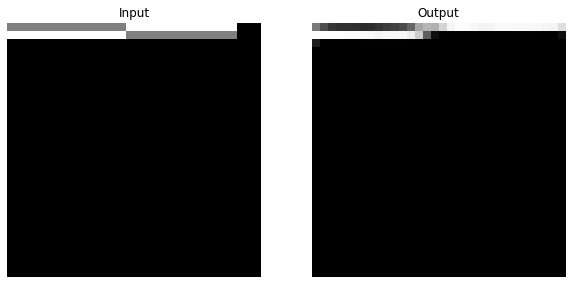

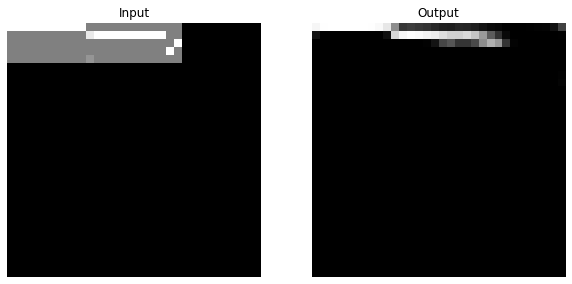

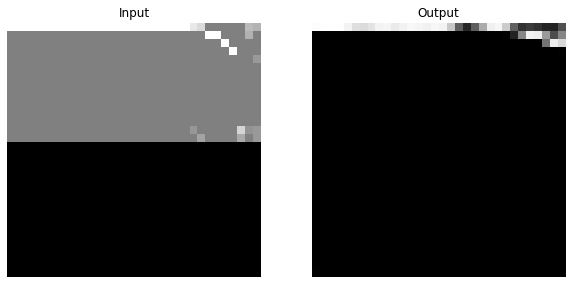

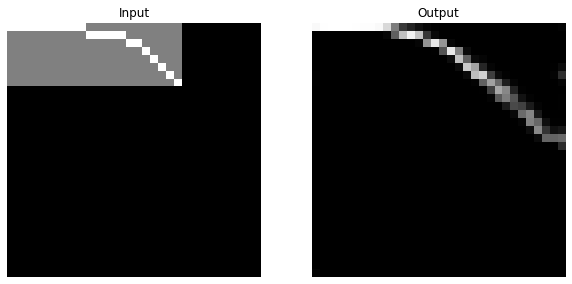

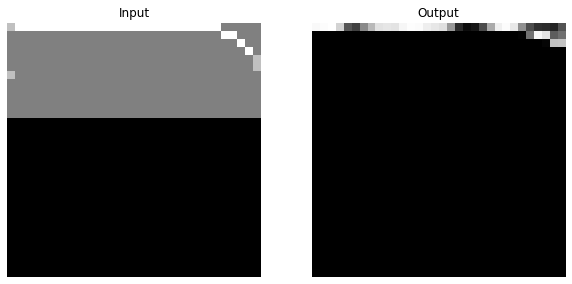

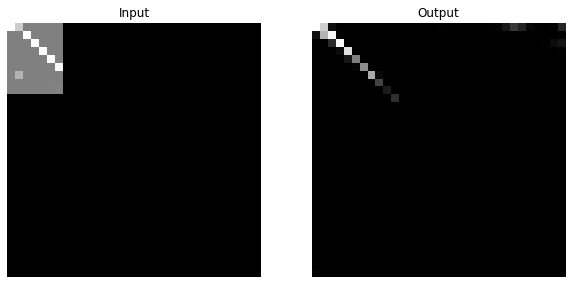

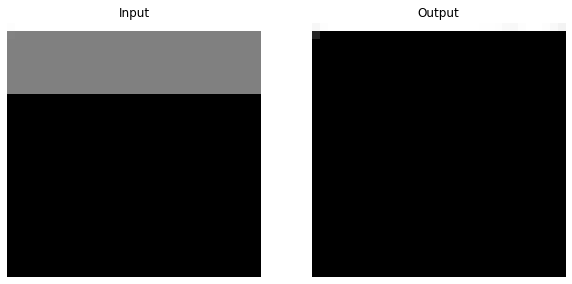

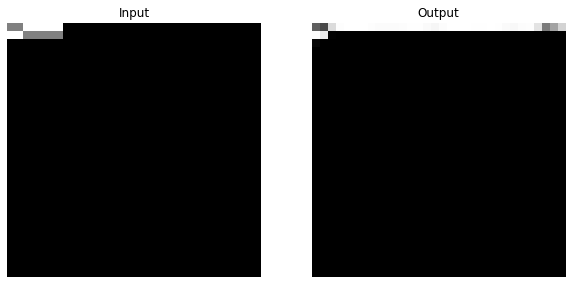

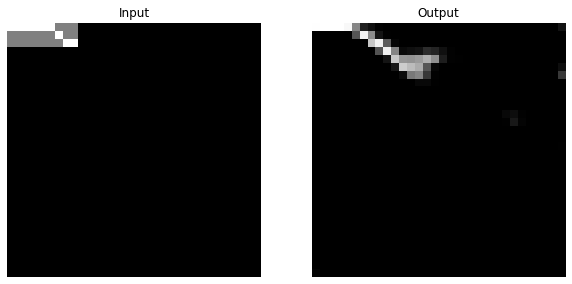

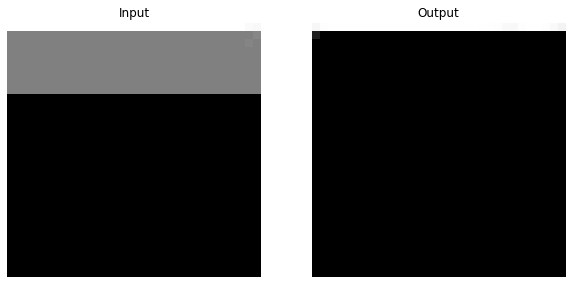

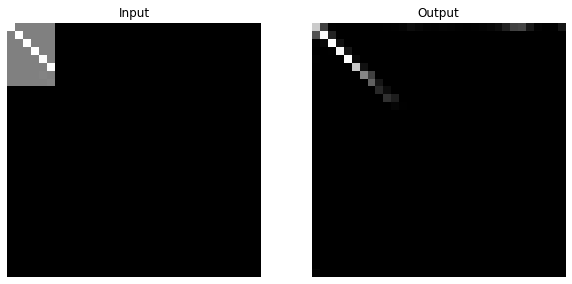

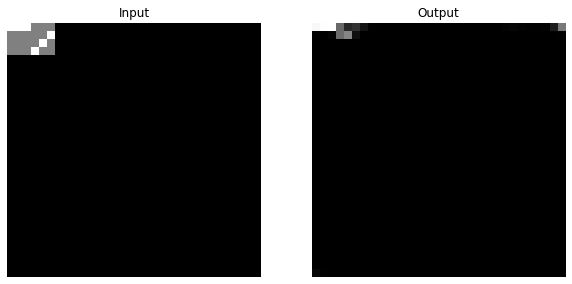

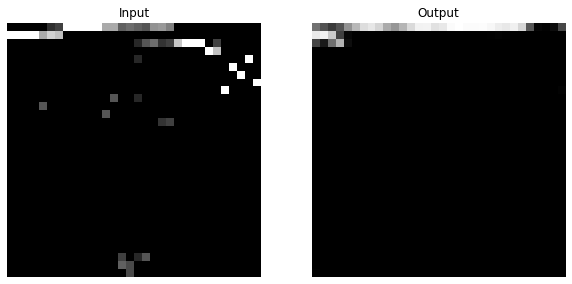

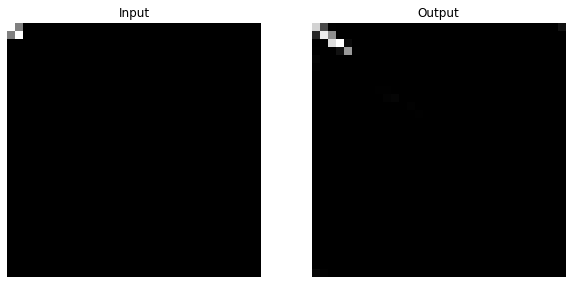

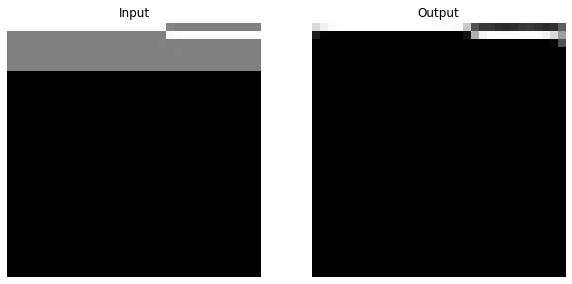

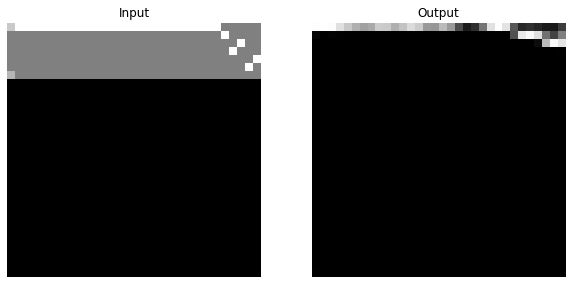

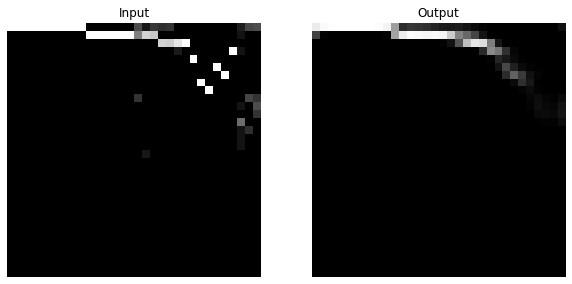

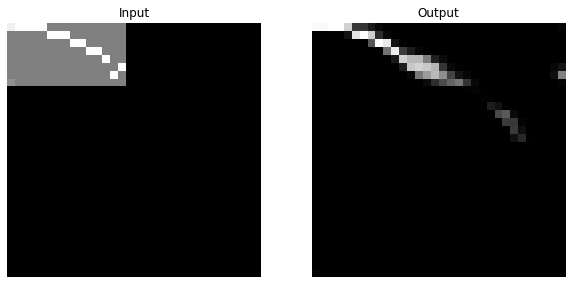

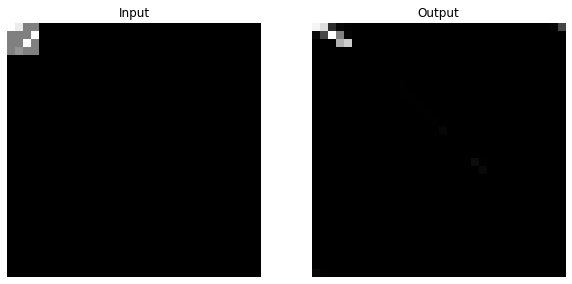

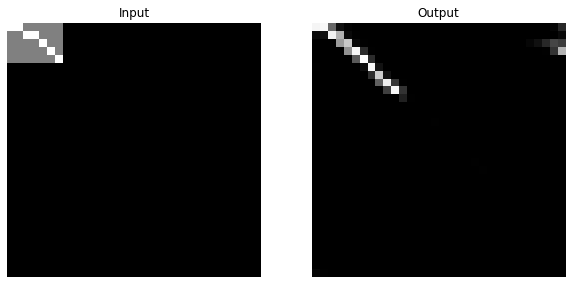

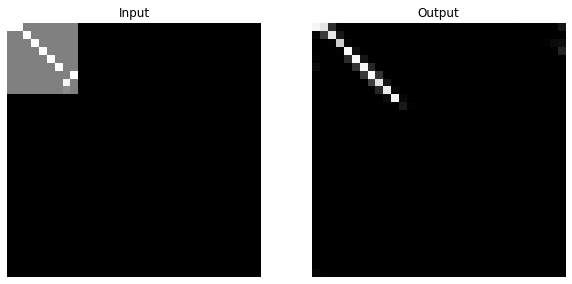

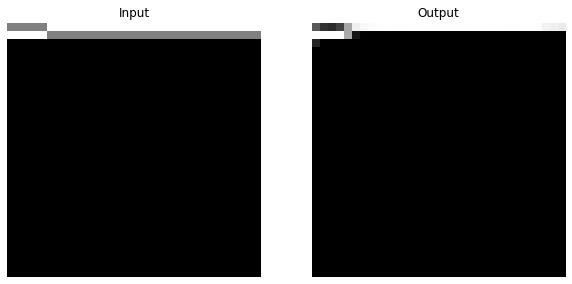

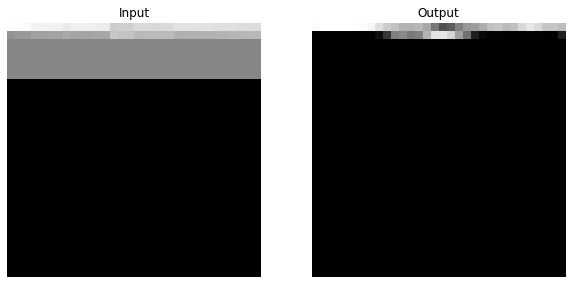

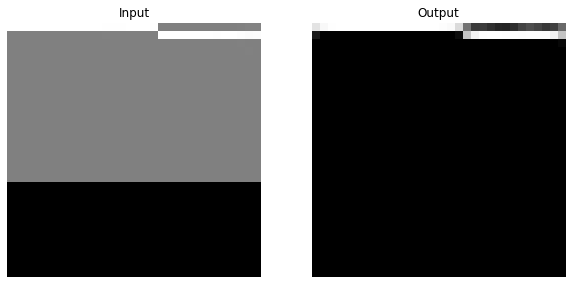

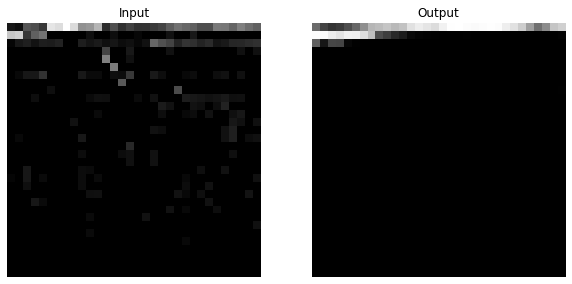

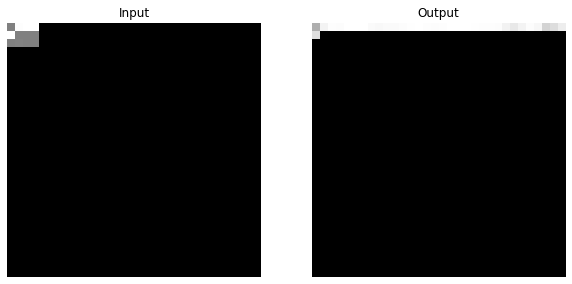

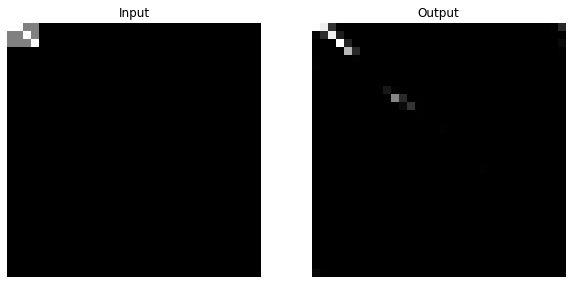

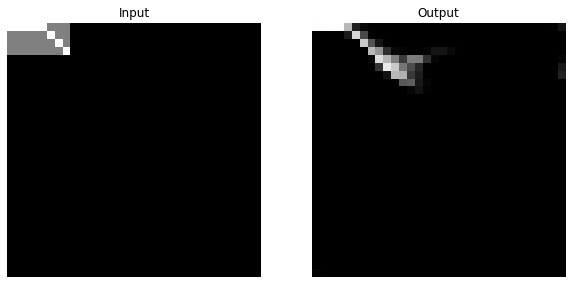

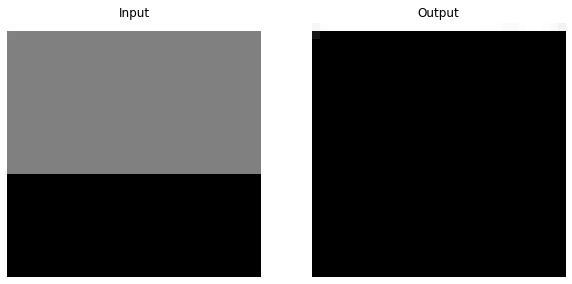

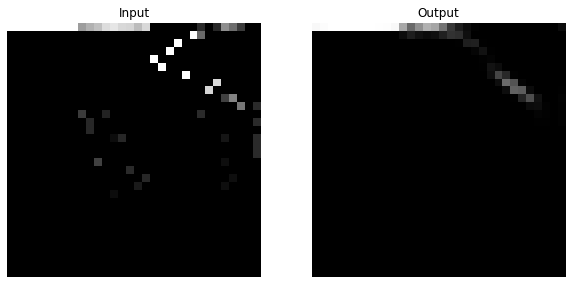

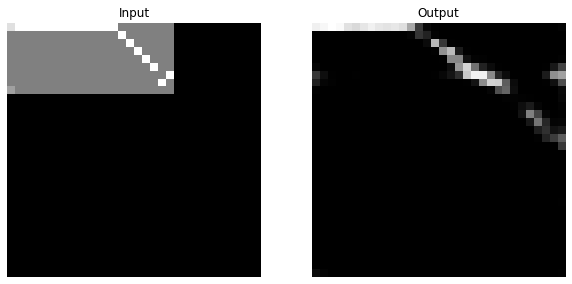

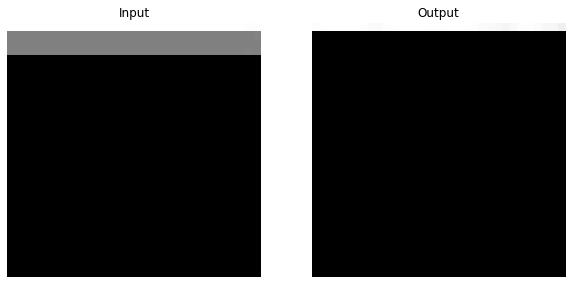

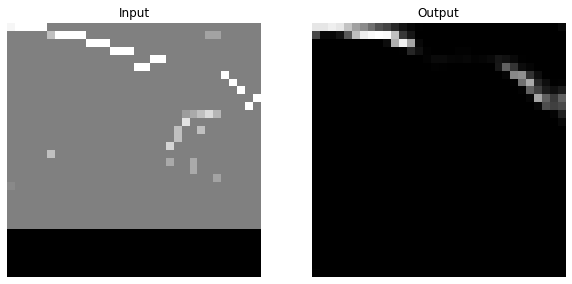

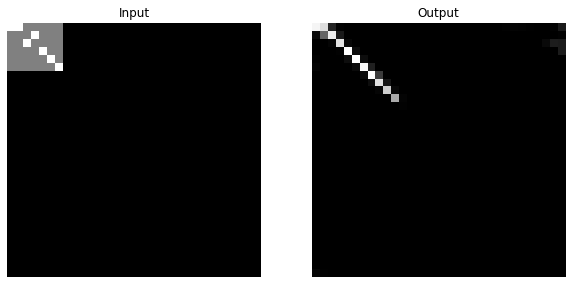

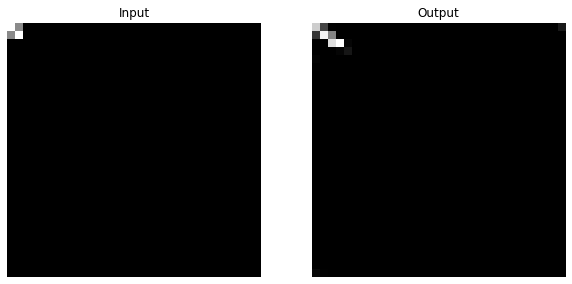

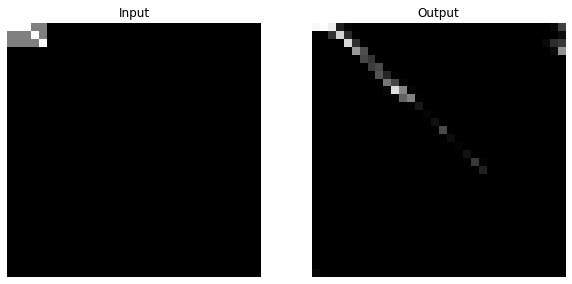

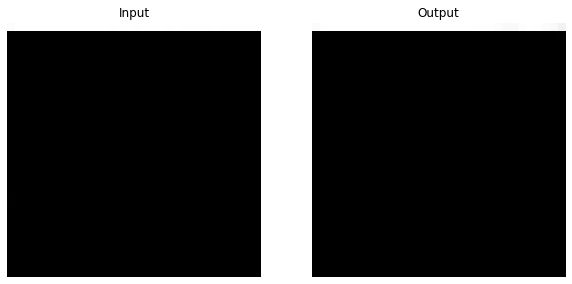

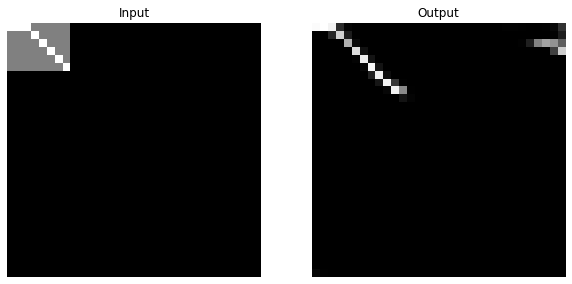

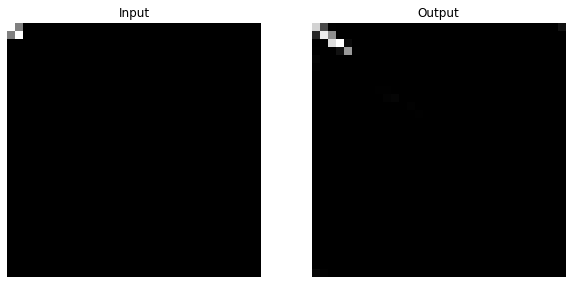

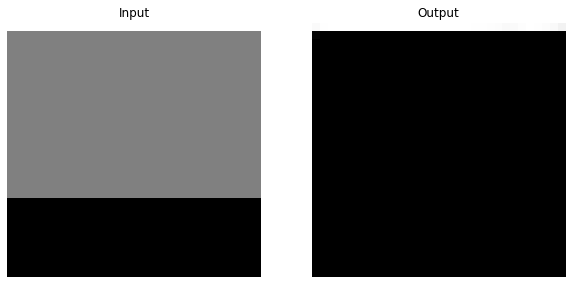

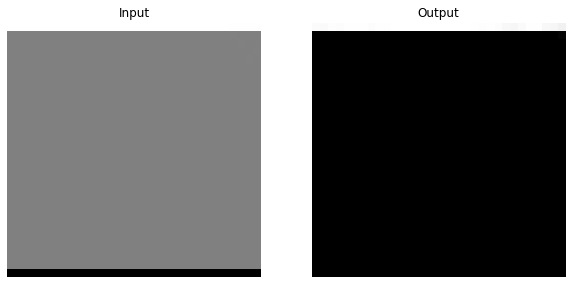

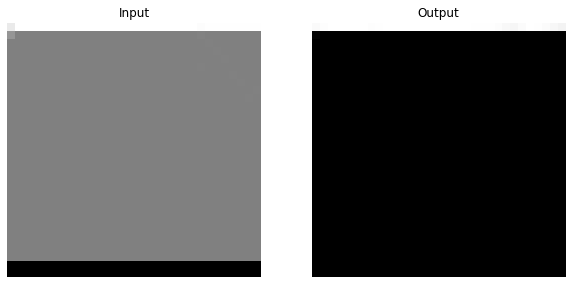

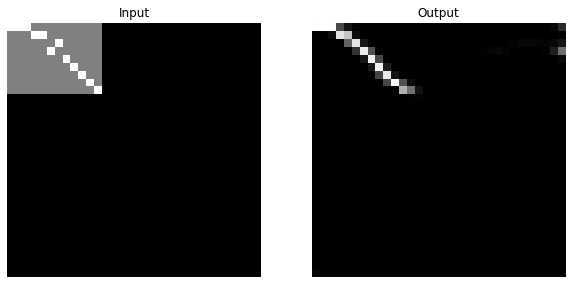

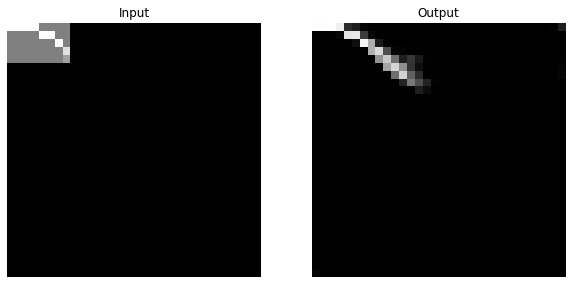

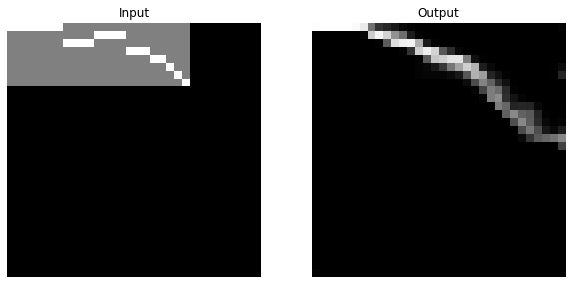

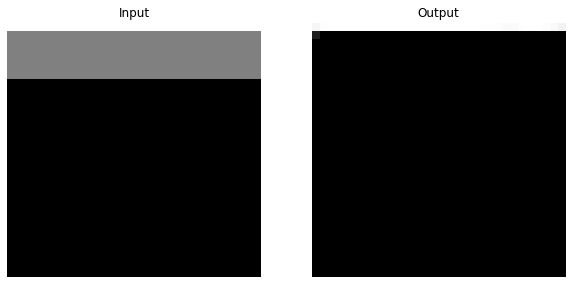

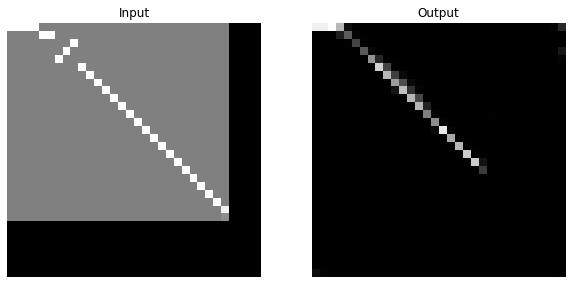

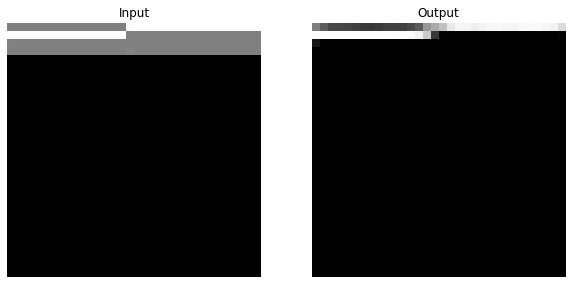

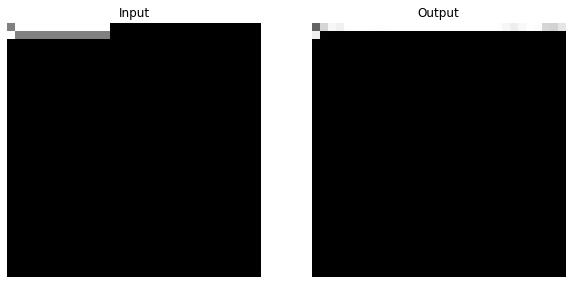

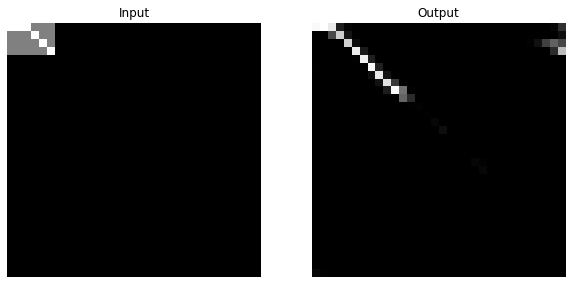

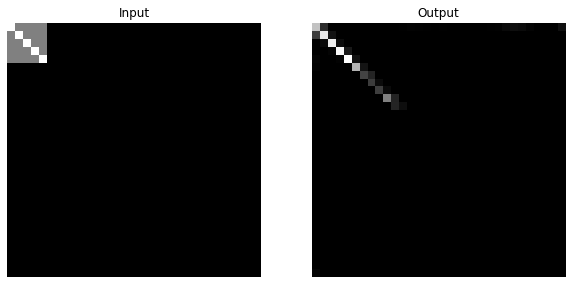

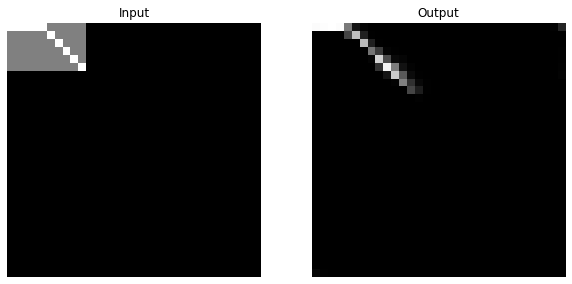

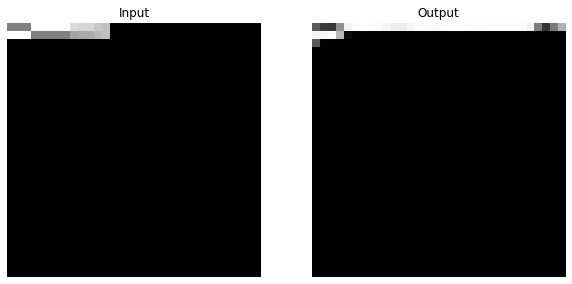

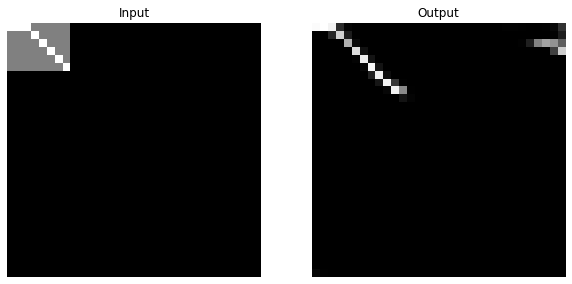

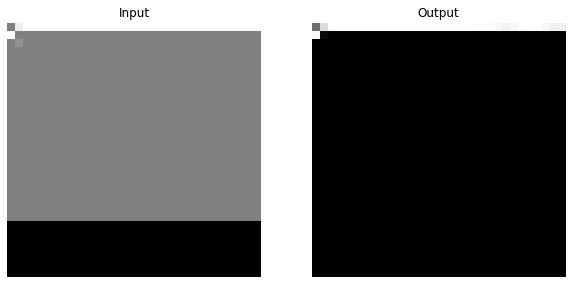

In [75]:
model.eval()

# Sample a couple of examples from the test DataLoader
num_samples = 2
for i, inputs in enumerate(test_loader):
    if i >= num_samples:
        break
    inputs = inputs.float().to(device)
    # Forward pass through the model
    outputs = model(inputs)
    # Convert inputs, outputs, and targets to numpy arrays
    inputs_np = inputs.cpu().numpy()
    outputs_np = outputs.cpu().detach().numpy()
    
    # Display input-output pairs
    for j in range(len(inputs)):
        input_image = inputs_np[j].squeeze()  # Assuming input is grayscale image
        output_image = outputs_np[j].squeeze()  # Assuming output is grayscale image
        
        # Plot input, output, and target images
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(input_image, cmap='gray')
        axes[0].set_title('Input')
        axes[0].axis('off')
        axes[1].imshow(output_image, cmap='gray')
        axes[1].set_title('Output')
        axes[1].axis('off')
        plt.show()

In [76]:
embeddings = model.encode(all_dat_tensor.float().to(device))

In [77]:
embeddings.shape

torch.Size([1328, 6])

In [327]:
pca_res_baseline = pca(np.array(all_dat).reshape(len(all_dat), -1), n_component=8)
umap_res_baseline = umap_reduce(pca_res_baseline)

/home/users/khoang99/.local/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:285: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [78]:
def umap_reduce(X, n_component = 2, scale = False, n_neighbors=15, min_dist=0.1):
    if scale:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
    umap_reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist)
    X = umap_reducer.fit_transform(X)
    return X

In [79]:
pca_res = pca(embeddings.cpu().detach().numpy(), n_component=2)
umap_res = umap_reduce(pca_res)

In [363]:
le = LabelEncoder()
anchor_event_c = le.fit_transform(df_anchor.anchor_event)

In [80]:

colors = [(1, 1, 1), (1, 0, 0)]  # White to red
cmap_name = 'white_red'
cmap_red = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors)

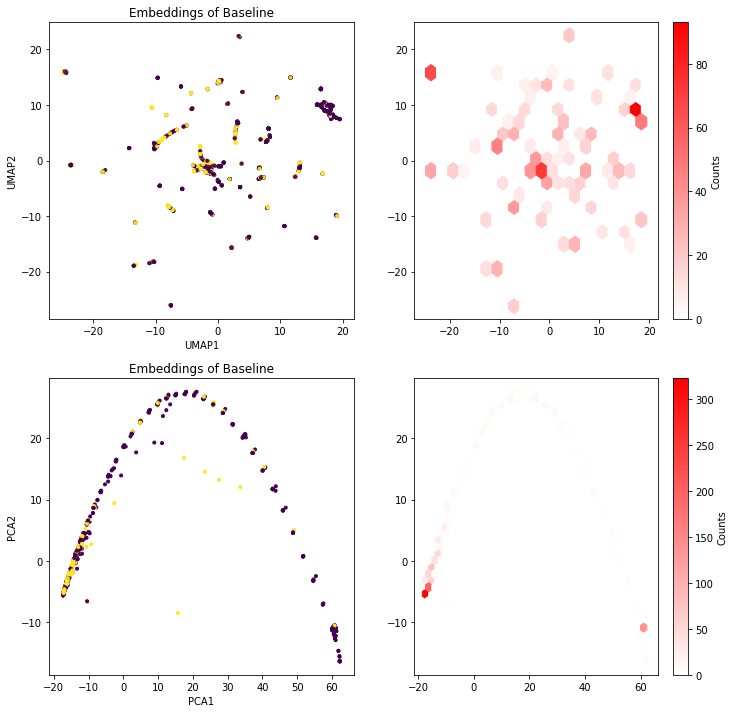

In [365]:
plt.figure(figsize =(12,12))
plt.subplot(221)
plt.scatter(umap_res_baseline.T[0], umap_res_baseline.T[1], \
            marker = ".", c=df_anchor.vdj, alpha = 0.9)
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.title("Embeddings of Baseline")
plt.subplot(222)
plt.hexbin(umap_res_baseline.T[0], umap_res_baseline.T[1], gridsize=20, cmap=cmap_red)
plt.colorbar(label='Counts')
plt.subplot(223)
plt.scatter(pca_res_baseline.T[0], pca_res_baseline.T[1], marker = ".", c=df_anchor.vdj)
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.title("Embeddings of Baseline")
plt.subplot(224)
plt.hexbin(pca_res_baseline.T[0], pca_res_baseline.T[1], gridsize=35, cmap=cmap_red)
plt.colorbar(label='Counts')
plt.show()

In [81]:
from sklearn.manifold import MDS
mds = MDS(n_components=2, metric=False)
mds_embeddings = mds.fit_transform(embeddings.cpu().detach().numpy())

Text(0.5, 1.0, 'Embeddings of Autoencoder')

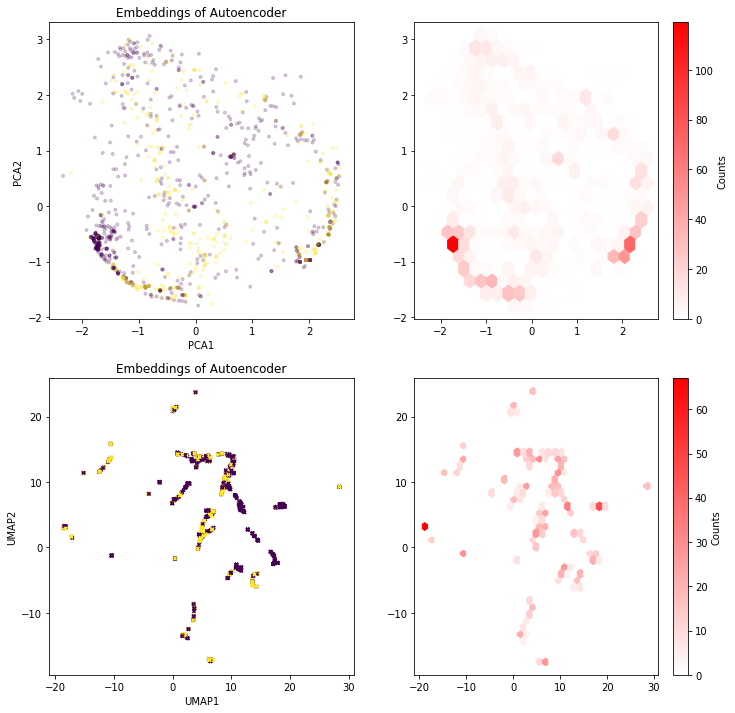

In [82]:
plt.figure(figsize =(12,12))

plt.subplot(222)

plt.hexbin(pca_res.T[0], pca_res.T[1], gridsize=20, cmap=cmap_red)
plt.colorbar(label='Counts')
plt.subplot(221)

plt.scatter(pca_res.T[0], pca_res.T[1], marker = ".", c=df_anchor.vdj, alpha = .2)
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.title("Embeddings of Autoencoder")
# plt.hexbin(pca_res.T[0], pca_res.T[1], gridsize=20, cmap='RdGy')
# plt.colorbar(label='Counts')
plt.subplot(224)

plt.hexbin(umap_res.T[0], umap_res.T[1], gridsize=35, cmap=cmap_red)
plt.colorbar(label='Counts')
plt.subplot(223)

plt.scatter(umap_res.T[0], umap_res.T[1], marker = "x", s = 10, c=df_anchor.vdj)
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.title("Embeddings of Autoencoder")
# plt.legend(handles=[
#     plt.Line2D([], [], color='blue', label='Line 1', marker='.'),
#     plt.Line2D([], [], color='red', label='Line 2', marker='.')
# ])

In [83]:
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering
from collections import Counter

In [91]:
spectral = SpectralClustering()
dbscan = DBSCAN(eps=.1, min_samples=30)
clusterer = dbscan
labels = clusterer.fit_predict(umap_res)
labels = clusterer.fit_predict(pca_res)

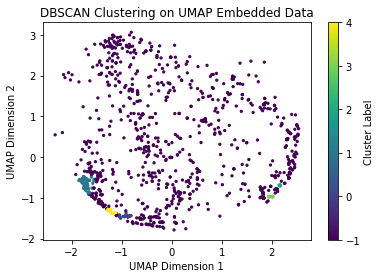

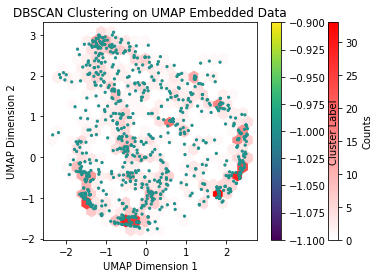

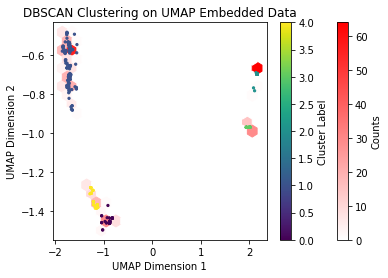

In [92]:
viz_data = pca_res

plt.scatter(viz_data[:, 0], viz_data[:, 1], c=labels, cmap='viridis', s=5)
plt.title('DBSCAN Clustering on UMAP Embedded Data')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.colorbar(label='Cluster Label')
plt.show()

df_viz = pd.DataFrame(viz_data)
df_viz["label"] = labels

exclude_list =[-1]

# plt.hexbin(pca_res.T[0], pca_res.T[1], gridsize=20, cmap=cmap_red)
# plt.colorbar(label='Counts')
# plt.subplot(221)
plt.hexbin(df_viz[df_viz["label"].isin(exclude_list)][0], \
            df_viz[df_viz["label"].isin(exclude_list)][1],\
            gridsize=20, cmap=cmap_red)

plt.colorbar(label='Counts')

plt.scatter(df_viz[df_viz["label"].isin(exclude_list)][0], \
            df_viz[df_viz["label"].isin(exclude_list)][1],\
            c=df_viz[df_viz["label"].isin(exclude_list)]["label"], cmap='viridis', s=5)
plt.title('DBSCAN Clustering on UMAP Embedded Data')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.colorbar(label='Cluster Label')
plt.show()

plt.hexbin(df_viz[~df_viz["label"].isin(exclude_list)][0], df_viz[~df_viz["label"].isin(exclude_list)][1],\
            gridsize=20, cmap=cmap_red)
plt.colorbar(label='Counts')

plt.scatter(df_viz[~df_viz["label"].isin(exclude_list)][0], df_viz[~df_viz["label"].isin(exclude_list)][1],\
            c=df_viz[~df_viz["label"].isin(exclude_list)]["label"], cmap='viridis', s=5)
plt.title('DBSCAN Clustering on UMAP Embedded Data')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.colorbar(label='Cluster Label')
plt.show()

# df_umap = pd.DataFrame(umap_res)
# df_umap["label"] = labels

In [93]:
df_viz["vdj"] = df_anchor.vdj.values

In [94]:
df_viz.groupby("label").count()

,0,1,vdj
label,,,
-1,971,971,971
0,42,42,42
1,172,172,172
2,66,66,66
3,44,44,44
4,33,33,33


In [95]:
df_viz.groupby("label").mean()

,0,1,vdj
label,,,
-1,0.146922,0.311235,0.409887
0,-0.898044,-1.451984,0.761905
1,-1.718512,-0.630219,0.029070
2,2.163779,-0.698276,0.348485
3,1.991259,-0.969596,0.409091
4,-1.205575,-1.335752,0.606061


In [96]:
df_viz.vdj.mean()

0.37349397590361444

In [114]:
len(set(labels))

9

In [138]:
anchor_lists = list(data_master.keys())

In [139]:
df_umap_clust = df_umap[~df_umap["label"].isin(exclude_list)]

In [140]:
anchor_in_clusters = [anchor_lists[i] for i in df_umap_clust.index]
df_umap_clust.loc[:,"anchor"] = anchor_in_clusters

/tmp/ipykernel_15810/2937896646.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_umap_clust.loc[:,"anchor"] = anchor_in_clusters


In [141]:
df_umap_clust.groupby("label").count()

,0,1,anchor
label,,,
0,139,139,139
2,60,60,60
3,208,208,208
4,42,42,42
5,124,124,124
6,137,137,137
7,42,42,42
8,47,47,47
9,123,123,123


In [38]:

interesting_clust = df_umap[(df_umap[0] > 10) & (df_umap[0] > 10) & (df_umap[1] < -10)].index # diagnal 4x4
interesting_clust = df_umap[(df_umap[0] < -10) & (df_umap[1] > 20)].index #diagnal 3x3
interesting_clust = df_umap[(df_umap[0] < -2) & (df_umap[1] < -10)].index #diagnal 2x2
interesting_clust = df_umap[(df_umap[0] > -4) & (df_umap[1] > 22)].index #diagnal 2x2


185
TGGGTGGCTATGTCTTCGGAACTGGGA
[[45  0]
 [ 0 25]]
123


/home/users/khoang99/.local/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:149: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


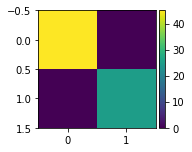

In [39]:
sample_index = random.sample(list(interesting_clust),1)[0]
print(sample_index)
print(list(data_master.keys())[sample_index])
plt.subplot(211)
print(data_matrix[sample_index])
print(len(interesting_clust))
io.imshow(data_matrix[sample_index])

<Axes: xlabel='0', ylabel='1'>

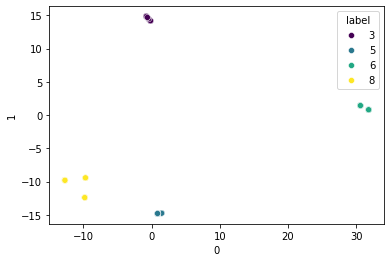

In [73]:
sns.scatterplot(data = df_umap_clust[df_umap_clust.label.isin([3,5, 6, 8])], x = 0 , y = 1, hue = "label", palette="viridis")

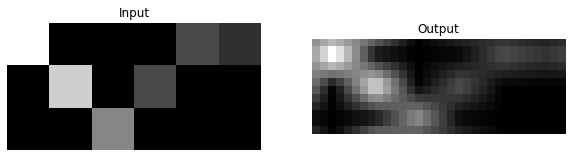

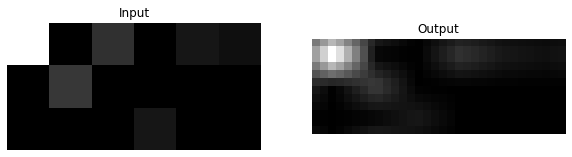

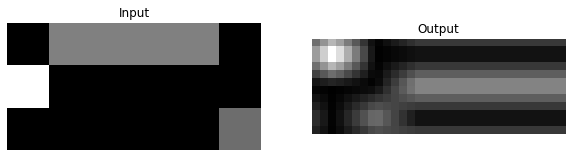

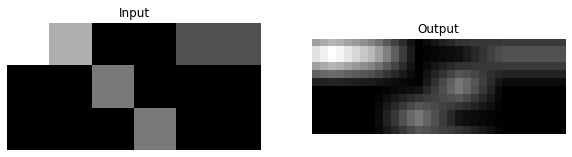

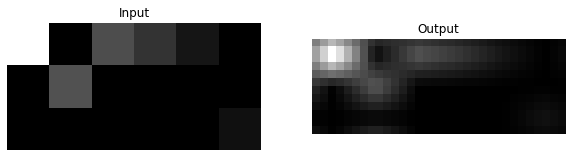

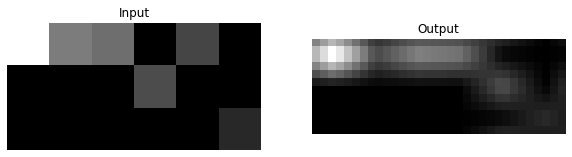

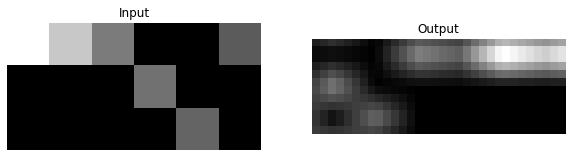

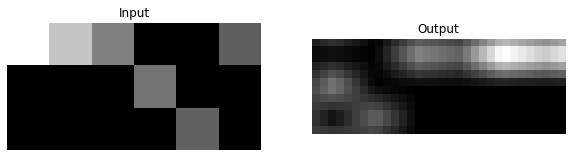

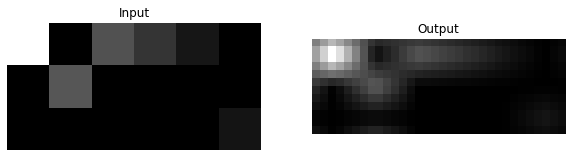

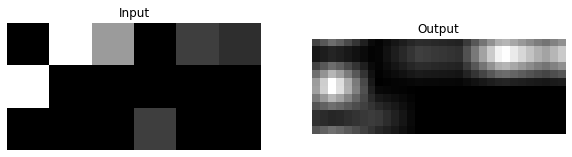

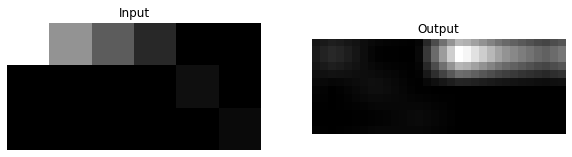

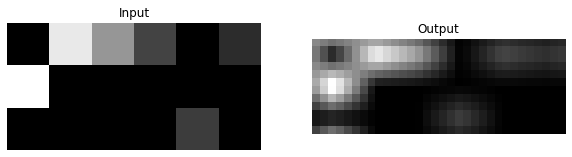

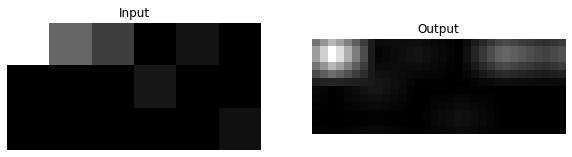

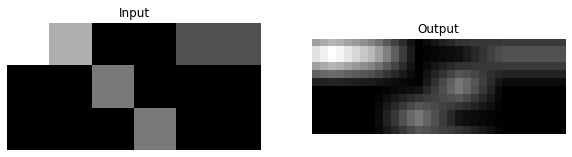

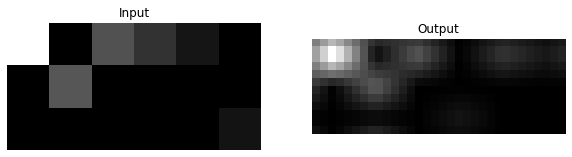

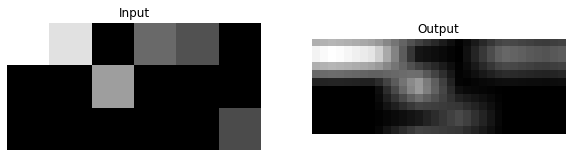

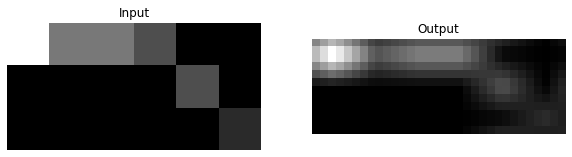

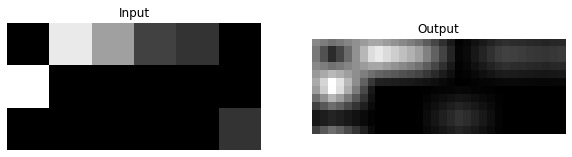

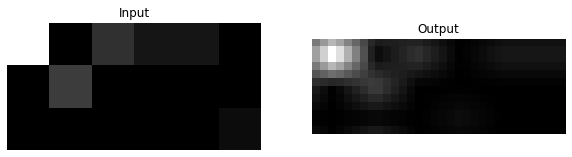

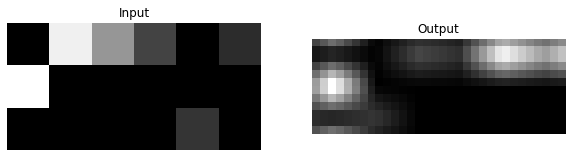

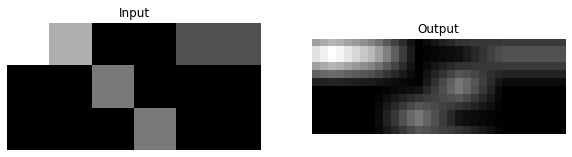

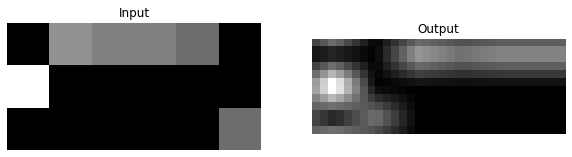

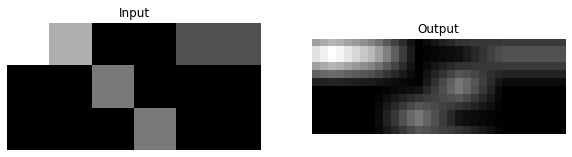

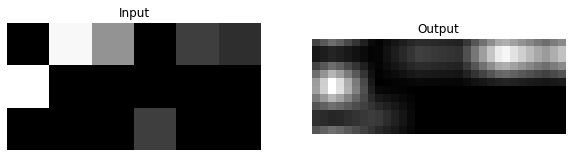

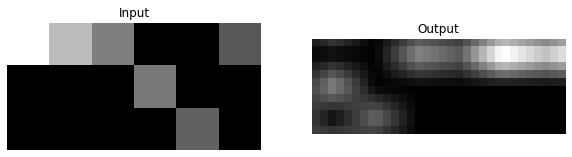

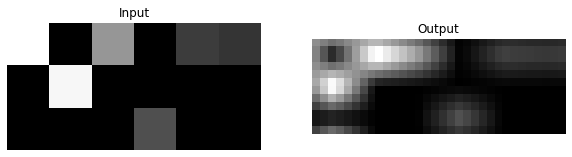

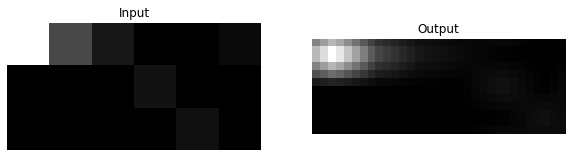

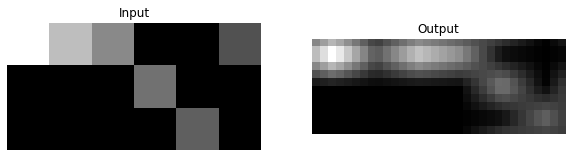

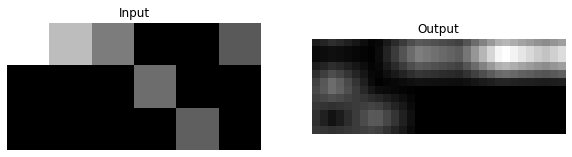

KeyboardInterrupt: 

In [151]:
interesting_anchors = [list(data_master.keys())[i] for i in interesting_clust]
interesting_anchors = df_umap_clust.groupby("label").agg(list)["anchor"][8]
for anchor in interesting_anchors:
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(data_master[anchor], cmap='gray')
    axes[0].set_title('Input')
    axes[0].axis('off')
    axes[1].imshow(prep_matrix(data_master[anchor]), cmap='gray')
    axes[1].set_title('Output')
    axes[1].axis('off')
    plt.show()